# Movie Data Analysis

## Business Understanding
The film industry is a dynamic global market, encompassing all stages of movie production and distribution and exerting significant cultural and economic influence. As more companies venture into original content creation, understanding which films resonate with audiences is crucial. Analyzing box office trends enables newcomers to identify popular genres, profitable themes, and audience preferences, guiding strategic production choices. This data-driven approach empowers new studios to craft compelling content that aligns with viewer interests, enhancing their potential to make a lasting impact in an increasingly competitive industry.

## Business Problem
ABC Company has observed that major corporations are increasingly investing in original video content, and they’re eager to join in. They’ve decided to establish a new movie studio but lack experience in film production. Your role is to analyze current box office trends to determine which types of films are performing best. You will then translate these findings into actionable insights for the head of the new movie studio, helping guide strategic decisions on the types of films to produce.

## Data sources
##### **Box Office Mojo**
Provides detailed box office earnings for movies, covering domestic and international markets. It may lack data for older or independent films, or films with limited releases, especially international earnings.

##### **IMDb**
Contains extensive movie data, including ratings, genres, budgets, and box office performance. Some older or independent films may have incomplete financial data or fewer reviews, and some records may lack cast or crew details.

##### **Rotten Tomatoes**
Offers critical reviews and audience scores for films. Gaps may exist for older or independent films, or those not widely reviewed, especially for regional or niche releases.

##### **TheMovieDB**
Includes detailed movie data like ratings, genres, and cast info. While comprehensive for popular films, it may have less data for obscure or older releases, and some films may lack images or crew details.

##### **The Numbers**
Focuses on financial data, including production budgets and box office earnings. Missing data may occur for independent or older films, particularly those with limited releases. It is focused on financials, rather than reviews or cast details.

## Objectives
- Identify High-Performing Genres
Analyze the genres of movies with the highest average ratings and box office success to determine which types of films resonate most with audiences. This will guide the studio in selecting the most profitable genres to produce.

- Evaluate Key Movie Attributes
Examine factors such as runtime, release year, and the number of votes to identify attributes correlated with higher audience ratings. These insights will help optimize the characteristics of films for better audience reception.

- Understand the Impact of Audience Engagement
Investigate the relationship between the number of votes and average ratings to assess the significance of audience engagement. This will inform strategies for marketing and audience outreach to enhance a film's visibility and success.

# Data Understanding

## IMDB data

In [513]:
# Importing the libraries
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from scipy import stats
from scipy.stats import linregress
from collections import Counter, defaultdict
import itertools
import warnings
import pickle

# Set default styles and warnings
sns.set(style="white", color_codes=True)
warnings.filterwarnings('ignore')
%matplotlib inline


In [514]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [515]:

zip_filename = "/content/drive/MyDrive/im.db.zip"

# Unzip the file
try:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall("output_directory")
    print("File extracted successfully!")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP archive.")
except Exception as e:
    print(f"An error occurred: {e}")


File extracted successfully!


In [516]:
# List the files in the current directory
os.listdir()


['.config', 'drive', 'plot.png', 'output_directory', 'sample_data']

In [517]:

# Create a connection to the SQLite database file
conn = sqlite3.connect('/content/output_directory/im.db')

# View all the tables in our database to determine which will be relevant for analysis
df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """
, conn
)

df[df['type'] == 'table']
# The movie_basics and movie_ratings are the most relevant

type           name       tbl_name  rootpage  \
0  table   movie_basics   movie_basics         2   
1  table      directors      directors         3   
2  table      known_for      known_for         4   
3  table     movie_akas     movie_akas         5   
4  table  movie_ratings  movie_ratings         6   
5  table        persons        persons         7   
6  table     principals     principals         8   
7  table        writers        writers         9   

                                                 sql  
0  CREATE TABLE "movie_basics" (\n"movie_id" TEXT...  
1  CREATE TABLE "directors" (\n"movie_id" TEXT,\n...  
2  CREATE TABLE "known_for" (\n"person_id" TEXT,\...  
3  CREATE TABLE "movie_akas" (\n"movie_id" TEXT,\...  
4  CREATE TABLE "movie_ratings" (\n"movie_id" TEX...  
5  CREATE TABLE "persons" (\n"person_id" TEXT,\n ...  
6  CREATE TABLE "principals" (\n"movie_id" TEXT,\...  
7  CREATE TABLE "writers" (\n"movie_id" TEXT,\n  ...

In [518]:
# View the first five rows of the movie_basics table
pd.read_sql("""
           SELECT * FROM movie_basics LIMIT 5;
            """, conn)

movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy

In [519]:
# View the first five rows of the movie_ratings table
pd.read_sql("""
           SELECT * FROM movie_ratings LIMIT 5;
            """, conn)

movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726            4.2     50352
4   tt1060240            6.5        21

In [520]:
# Create a dataframe containing the movie_basics table
movie_basics_df = pd.read_sql("""
                                SELECT * FROM movie_basics;
                              """, conn)

In [521]:
# Create a dataframe containing the movie_ratings table
movie_ratings_df = pd.read_sql("""
                                SELECT * FROM movie_ratings;
                              """, conn)

In [522]:
# Merge the movie_ratings and movie_basics table on the movie_id column
merged_df = pd.merge(movie_basics_df, movie_ratings_df, on="movie_id", how="inner")
merged_df

movie_id                    primary_title              original_title  \
0      tt0063540                        Sunghursh                   Sunghursh   
1      tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2      tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3      tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4      tt0100275         The Wandering Soap Opera       La Telenovela Errante   
...          ...                              ...                         ...   
73851  tt9913084                 Diabolik sono io            Diabolik sono io   
73852  tt9914286                Sokagin Çocuklari           Sokagin Çocuklari   
73853  tt9914642                        Albatross                   Albatross   
73854  tt9914942       La vida sense la Sara Amat  La vida sense la Sara Amat   
73855  tt9916160                       Drømmeland                  Drømmeland   

       start_year  runtime_minutes                genres  averagerating  \
0            2013            175.0    Action,Crime,Drama            7.0   
1            2019            114.0       Biography,Drama            7.2   
2            2018            122.0                 Drama            6.9   
3            2018              NaN          Comedy,Drama            6.1   
4            2017             80.0  Comedy,Drama,Fantasy            6.5   
...           ...              ...                   ...            ...   
73851        2019             75.0           Documentary            6.2   
73852        2019             98.0          Drama,Family            8.7   
73853        2017              NaN           Documentary            8.5   
73854        2019              NaN                  None            6.6   
73855        2019             72.0           Documentary            6.5   

       numvotes  
0            77  
1            43  
2          4517  
3            13  
4           119  
...         ...  
73851         6  
73852       136  
73853         8  
73854         5  
73855        11  

[73856 rows x 8 columns]

In [523]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [524]:
merged_df.shape

(73856, 8)

In [525]:
merged_df.describe()

start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000  2.820000e+02
max     2019.000000     51420.000000      10.000000  1.841066e+06

# The Numbers Data

In [526]:
#load the data
#file path = 'tn.movie_budgets.csv.gz'
df = pd.read_csv('/content/drive/MyDrive/tn.movie_budgets.csv.gz', compression='gzip')

In [527]:
#five rows
df.head()

id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
2   3   Jun 7, 2019                                 Dark Phoenix   
3   4   May 1, 2015                      Avengers: Age of Ultron   
4   5  Dec 15, 2017            Star Wars Ep. VIII: The Last Jedi   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875  
2      $350,000,000    $42,762,350    $149,762,350  
3      $330,600,000   $459,005,868  $1,403,013,963  
4      $317,000,000   $620,181,382  $1,316,721,747

In [528]:
# Remove '$' and ',' symbols and convert to numeric
numeric_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in numeric_columns:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [529]:
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'])


In [530]:
#checking number of rows and columns
df.shape

(5782, 6)

In [531]:
#overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


In [532]:
#checking for missing values
df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [533]:
#checking for duplicates
df.duplicated().sum()

0

## Box Office Mojo Data

In [534]:
#Loading bom.movie_gross.csv.gz, displaying the first five rows of the data set and get a summary of information the data set.
bom = pd.read_csv('/content/drive/MyDrive/bom.movie_gross.csv.gz')
bom.head()
bom.info()
bom

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  
0        652000000  2010  
1        691300000  2010  
2        664300000  2010  
3        535700000  2010  
4        513900000  2010  
...            ...   ...  
3382           NaN  2018  
3383           NaN  2018  
3384           NaN  2018  
3385           NaN  2018  
3386           NaN  2018  

[3387 rows x 5 columns]

In [535]:
# To check the shape of the data.
rows=bom.shape[0]
columns=bom.shape[1]
print(f"Bom data set has {rows} rows and {columns} columns")

Bom data set has 3387 rows and 5 columns


In [536]:
#To check the descriptive statistics for the columns of the bom data.
bom.describe()

domestic_gross         year
count    3.359000e+03  3387.000000
mean     2.874585e+07  2013.958075
std      6.698250e+07     2.478141
min      1.000000e+02  2010.000000
25%      1.200000e+05  2012.000000
50%      1.400000e+06  2014.000000
75%      2.790000e+07  2016.000000
max      9.367000e+08  2018.000000

## Rotten Tomatoes Data


In [537]:
#  create avariable named reviews_df and load the data
reviews_df = pd.read_csv('/content/drive/MyDrive/rt.reviews.tsv.gz', sep='\t', encoding='latin1')

In [538]:
reviews_df.head()

id                                             review rating   fresh  \
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh   
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   
2   3  ... life lived in a bubble in financial dealin...    NaN   fresh   
3   3  Continuing along a line introduced in last yea...    NaN   fresh   
4   3             ... a perverse twist on neorealism...     NaN   fresh   

           critic  top_critic         publisher               date  
0      PJ Nabarro           0   Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0           io9.com       May 23, 2018  
2    Sean Axmaker           0  Stream on Demand    January 4, 2018  
3   Daniel Kasman           0              MUBI  November 16, 2017  
4             NaN           0      Cinema Scope   October 12, 2017

In [539]:
#check the shape of our dataframe
reviews_df.shape

(54432, 8)

In [540]:
# check for info printout of the dataframe
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


## Rotten Tomatoes Movie Info Data

In [541]:
file_path = '/content/drive/MyDrive/rt.movie_info.tsv.gz'

df_rt = pd.read_csv(file_path, sep='\t', compression='gzip', encoding='ISO-8859-1')

df_rt.head()


id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   
2   5  Illeana Douglas delivers a superb performance ...      R   
3   6  Michael Douglas runs afoul of a treacherous su...      R   
4   7                                                NaN     NR   

                                 genre          director  \
0  Action and Adventure|Classics|Drama  William Friedkin   
1    Drama|Science Fiction and Fantasy  David Cronenberg   
2    Drama|Musical and Performing Arts    Allison Anders   
3           Drama|Mystery and Suspense    Barry Levinson   
4                        Drama|Romance    Rodney Bennett   

                            writer  theater_date      dvd_date currency  \
0                   Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN   
1     David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
2                   Allison Anders  Sep 13, 1996  Apr 18, 2000      NaN   
3  Paul Attanasio|Michael Crichton   Dec 9, 1994  Aug 27, 1997      NaN   
4                     Giles Cooper           NaN           NaN      NaN   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
2        NaN  116 minutes                NaN  
3        NaN  128 minutes                NaN  
4        NaN  200 minutes                NaN

In [542]:
#Data summary
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [543]:
# Data description
df_rt.describe()

id
count  1560.000000
mean   1007.303846
std     579.164527
min       1.000000
25%     504.750000
50%    1007.500000
75%    1503.250000
max    2000.000000

# Data Preperation

## IMDb Data

In [544]:
merged_df.isna().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64

In [545]:
# Replace null values in the 'genres' column with "Unknown"
merged_df['genres'] = merged_df['genres'].fillna('Unknown')

# Verify the replacement
print(merged_df['genres'].isnull().sum())


0


In [546]:
# drop rows with missing values which will be the rows with missing values in the runtime_minutes column
merged_df = merged_df.dropna()

In [547]:
# Check for duplicates
merged_df.duplicated().sum()

0

In [548]:
# View information on the cleaned data
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66236 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         66236 non-null  object 
 1   primary_title    66236 non-null  object 
 2   original_title   66236 non-null  object 
 3   start_year       66236 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           66236 non-null  object 
 6   averagerating    66236 non-null  float64
 7   numvotes         66236 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


## The Numbers Data

## Box Office Mojo Data

In [549]:
# Checking for missing values.
missing_bom=bom.isnull().sum()
print(type(missing_bom))
print(missing_bom)

<class 'pandas.core.series.Series'>
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64


In [550]:
# Check for all the numerical columns
numerical_columns = bom.select_dtypes(include=['number']).columns
print(f"The numerical columns include: {numerical_columns}")

The numerical columns include: Index(['domestic_gross', 'year'], dtype='object')


In [551]:
# Check for the categorical columns.
categorical_columns = bom.select_dtypes(include=['object', 'category']).columns
print(f"The categorical columns include: {categorical_columns}")

The categorical columns include: Index(['title', 'studio', 'foreign_gross'], dtype='object')


In [552]:
# Creating a copy of the original data set.
bom_clean = bom.copy()
bom_clean

title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  
0        652000000  2010  
1        691300000  2010  
2        664300000  2010  
3        535700000  2010  
4        513900000  2010  
...            ...   ...  
3382           NaN  2018  
3383           NaN  2018  
3384           NaN  2018  
3385           NaN  2018  
3386           NaN  2018  

[3387 rows x 5 columns]

In [553]:
bom_clean.isna().sum()# drop missing values in every colum
for column in bom_clean.columns:
   bom_clean = bom_clean.dropna(subset=[column])

bom_clean.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [554]:
bom_clean.head()
bom_clean.info()
bom_clean

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


title        studio  \
0                                           Toy Story 3            BV   
1                            Alice in Wonderland (2010)            BV   
2           Harry Potter and the Deathly Hallows Part 1            WB   
3                                             Inception            WB   
4                                   Shrek Forever After          P/DW   
...                                                 ...           ...   
3275                                    I Still See You           LGF   
3286                              The Catcher Was a Spy           IFC   
3309                                         Time Freak    Grindstone   
3342  Reign of Judges: Title of Liberty - Concept Short  Darin Southa   
3353            Antonio Lopez 1970: Sex Fashion & Disco            FM   

      domestic_gross foreign_gross  year  
0        415000000.0     652000000  2010  
1        334200000.0     691300000  2010  
2        296000000.0     664300000  2010  
3        292600000.0     535700000  2010  
4        238700000.0     513900000  2010  
...              ...           ...   ...  
3275          1400.0       1500000  2018  
3286        725000.0        229000  2018  
3309         10000.0        256000  2018  
3342         93200.0          5200  2018  
3353         43200.0         30000  2018  

[2007 rows x 5 columns]

In [555]:
# Rename the column.
bom_clean= bom_clean.rename(columns={'title': 'movie title'})
bom_clean.head()

movie title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010

In [556]:
# Convert foreign gross from string to numeric
bom_clean['foreign_gross'] = pd.to_numeric(bom_clean['foreign_gross'], errors='coerce')
bom_clean.head(2)

movie title studio  domestic_gross  foreign_gross  year
0                 Toy Story 3     BV     415000000.0    652000000.0  2010
1  Alice in Wonderland (2010)     BV     334200000.0    691300000.0  2010

In [557]:
# Combine columns  to create new coluumn
bom_clean['total_gross'] = bom_clean['domestic_gross'] + bom_clean['foreign_gross']
bom_clean.head(2)

movie title studio  domestic_gross  foreign_gross  year  \
0                 Toy Story 3     BV     415000000.0    652000000.0  2010   
1  Alice in Wonderland (2010)     BV     334200000.0    691300000.0  2010   

    total_gross  
0  1.067000e+09  
1  1.025500e+09

In [558]:
bom_clean = bom_clean.dropna(subset=['total_gross'])


In [559]:
# checking how many duplicate rows exist in our DataFrame
bom_clean.duplicated().sum()

0

In [560]:
# Check for outliers in  all the numerical columns
numerical_columns = bom_clean.select_dtypes(include=['number']).columns
print(f"The numerical columns include: {numerical_columns}")

The numerical columns include: Index(['domestic_gross', 'foreign_gross', 'year', 'total_gross'], dtype='object')


In [561]:
# List of numerical columns in the dataset
numerical_columns = ['domestic_gross','foreign_gross', 'year', 'total_gross']

# Defining a function to check and count outliers using the IQR method
def check_outliers_iqr(bom_clean, numerical_columns):
    outliers_count = {}
    for column in numerical_columns:
        # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
        Q1 = bom_clean[column].quantile(0.25)
        Q3 = bom_clean[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify and count outliers
        outliers = bom_clean[(bom_clean[column] < lower_bound) | (bom_clean[column] > upper_bound)]
        outliers_count[column] = len(outliers)  # Store outliers count for each column

    return outliers_count

# Get the count of outliers in each numerical column
outliers_count = check_outliers_iqr(bom_clean, numerical_columns)

# Print the outliers count for each column
for column, count in outliers_count.items():
    print(f"Outliers in '{column}': {count}")


Outliers in 'domestic_gross': 178
Outliers in 'foreign_gross': 253
Outliers in 'year': 0
Outliers in 'total_gross': 216


## Rotten Tomatoes Data


In [562]:
reviews_df.isna().mean()*100

id             0.000000
review        10.220091
rating        24.832819
fresh          0.000000
critic         5.000735
top_critic     0.000000
publisher      0.567681
date           0.000000
dtype: float64

In [563]:
# checking how many missing values
reviews_df['rating'].isna().sum()

13517

Extract the numerical part of the rating(e.g,"4" from "4/5")

Then convert it to a numeric (float) format for easier imputation and analysis

After converting to numeric format,handle missing values using appropriate imputation techniques

Find a meaningful placeholder to replace ratings with a placeholder value e.g "-1" to distinguish them from observed ratings and help in converting the rating into numeric values. All missing values will be replaced with -1.0.  

In [564]:
# Extracting the numerical part of rating column
reviews_df["rating"] = reviews_df["rating"].str.extract(r'(\d+)').astype(float)

In [565]:
# Replace NaN with placeholder "-1"
reviews_df["rating"].fillna(-1,inplace=True)

In [566]:
# Checking if the rating column has been converted to float data type
reviews_df['rating'].value_counts()

rating
-1.0    19985
 3.0    11240
 2.0     9399
 4.0     5592
 1.0     3626
 5.0     1696
 7.0      739
 8.0      719
 6.0      613
 0.0      458
 9.0      365
Name: count, dtype: int64

For the "Publisher","Critic" and "Review" columns replace missing values with "Unknown", to avoid data loss,thus
preserving the maximum amount of data available for analysis.

In [567]:
# checking how many missing values
reviews_df['publisher'].isna().sum()

309

In [568]:
#replacing missing values with "unknown"
reviews_df['publisher'] = reviews_df['publisher'].fillna('Unknown')

In [569]:
#replacing review missing values with "Not Given"
reviews_df['review'] = reviews_df['review'].fillna("Not Given")

In [570]:
#replacing critic missing values with "Unknown"
reviews_df['critic'] = reviews_df['critic'].fillna('Uknown')

In [571]:
#check if there more missing values
reviews_df.isna().sum()

id            0
review        0
rating        0
fresh         0
critic        0
top_critic    0
publisher     0
date          0
dtype: int64

In [572]:
# check for duplicates
reviews_df.duplicated().sum()

16

In [573]:
#drop all the duplicates
reviews_df = reviews_df.drop_duplicates()

In [574]:
# fresh column into boolean
reviews_df['fresh'] = reviews_df['fresh'].map({"fresh": True, "rotten": False})
reviews_df['fresh'].head()

0     True
1    False
2     True
3     True
4     True
Name: fresh, dtype: bool

In [575]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

In [576]:
# Remove leading and trailing spaces and capitalize each word
reviews_df['critic'] = reviews_df['critic'].str.strip().str.title()
reviews_df['critic'].head()

0        Pj Nabarro
1    Annalee Newitz
2      Sean Axmaker
3     Daniel Kasman
4            Uknown
Name: critic, dtype: object

In [577]:
# Remove leading and trailing spaces and capitalize each word
reviews_df['publisher'] = reviews_df['publisher'].str.strip().str.title()
reviews_df['publisher'].head()

0     Patrick Nabarro
1             Io9.Com
2    Stream On Demand
3                Mubi
4        Cinema Scope
Name: publisher, dtype: object

In [578]:
#See all value occurences across all columns
cols = ['id','rating','fresh','critic','top_critic','publisher','date']
for col in reviews_df[cols].columns:
    print(reviews_df[col].value_counts().nlargest(5))
    print('\n---\n')

id
782     338
1067    275
1525    262
1777    260
1083    260
Name: count, dtype: int64

---

rating
-1.0    19984
 3.0    11237
 2.0     9395
 4.0     5587
 1.0     3625
Name: count, dtype: int64

---

fresh
True     33026
False    21390
Name: count, dtype: int64

---

critic
Uknown             2706
Emanuel Levy        595
Roger Ebert         461
Dennis Schwartz     413
Nell Minow          372
Name: count, dtype: int64

---

top_critic
0    41320
1    13096
Name: count, dtype: int64

---

publisher
Efilmcritic.Com         673
Emanuellevy.Com         591
New York Times          590
Washington Post         565
Entertainment Weekly    541
Name: count, dtype: int64

---

date
2000-01-01    4303
2003-05-20     202
2005-12-06     171
2011-09-07     124
2002-07-26     121
Name: count, dtype: int64

---



## Rotten Tomatoes Movie Info Data

In [579]:
# Checking for missing values
df_rt.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [580]:
# Checking for unique values (e.g., genre)
df_rt['genre'].unique()


array(['Action and Adventure|Classics|Drama',
       'Drama|Science Fiction and Fantasy',
       'Drama|Musical and Performing Arts', 'Drama|Mystery and Suspense',
       'Drama|Romance', 'Drama|Kids and Family', 'Comedy', 'Drama',
       'Action and Adventure|Mystery and Suspense|Science Fiction and Fantasy',
       nan, 'Documentary', 'Documentary|Special Interest',
       'Classics|Comedy|Drama', 'Comedy|Drama|Mystery and Suspense',
       'Action and Adventure|Comedy|Drama',
       'Action and Adventure|Drama|Science Fiction and Fantasy',
       'Art House and International|Comedy|Drama|Musical and Performing Arts',
       'Musical and Performing Arts',
       'Classics|Comedy|Musical and Performing Arts|Romance',
       'Action and Adventure|Drama|Mystery and Suspense',
       'Action and Adventure|Mystery and Suspense',
       'Art House and International|Classics|Horror|Mystery and Suspense',
       'Horror',
       'Action and Adventure|Classics|Drama|Mystery and Suspense',
   

In [581]:
# Dropping rows with null values
df_cleaned2 = df_rt.dropna()

# Displaying cleaned data
df_cleaned2.head()

id                                           synopsis rating  \
1    3  New York City, not-too-distant-future: Eric Pa...      R   
6   10  Some cast and crew from NBC's highly acclaimed...  PG-13   
7   13  Stewart Kane, an Irishman living in the Austra...      R   
15  22  Two-time Academy Award Winner Kevin Spacey giv...      R   
18  25  From ancient Japan's most enduring tale, the e...  PG-13   

                                                genre             director  \
1                   Drama|Science Fiction and Fantasy     David Cronenberg   
6                                              Comedy          Jake Kasdan   
7                                               Drama         Ray Lawrence   
15                  Comedy|Drama|Mystery and Suspense  George Hickenlooper   
18  Action and Adventure|Drama|Science Fiction and...     Carl Erik Rinsch   

                              writer  theater_date      dvd_date currency  \
1       David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
6                         Mike White  Jan 11, 2002  Jun 18, 2002        $   
7   Raymond Carver|Beatrix Christian  Apr 27, 2006   Oct 2, 2007        $   
15                     Norman Snider  Dec 17, 2010   Apr 5, 2011        $   
18        Chris Morgan|Hossein Amini  Dec 25, 2013   Apr 1, 2014        $   

    box_office      runtime                  studio  
1      600,000  108 minutes       Entertainment One  
6   41,032,915   82 minutes      Paramount Pictures  
7      224,114  123 minutes  Sony Pictures Classics  
15   1,039,869  108 minutes            ATO Pictures  
18  20,518,224  127 minutes      Universal Pictures

In [582]:
# Dropping rows with null values
df_rt.dropna(inplace=True)

# Display the data
df_rt.head()


id                                           synopsis rating  \
1    3  New York City, not-too-distant-future: Eric Pa...      R   
6   10  Some cast and crew from NBC's highly acclaimed...  PG-13   
7   13  Stewart Kane, an Irishman living in the Austra...      R   
15  22  Two-time Academy Award Winner Kevin Spacey giv...      R   
18  25  From ancient Japan's most enduring tale, the e...  PG-13   

                                                genre             director  \
1                   Drama|Science Fiction and Fantasy     David Cronenberg   
6                                              Comedy          Jake Kasdan   
7                                               Drama         Ray Lawrence   
15                  Comedy|Drama|Mystery and Suspense  George Hickenlooper   
18  Action and Adventure|Drama|Science Fiction and...     Carl Erik Rinsch   

                              writer  theater_date      dvd_date currency  \
1       David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
6                         Mike White  Jan 11, 2002  Jun 18, 2002        $   
7   Raymond Carver|Beatrix Christian  Apr 27, 2006   Oct 2, 2007        $   
15                     Norman Snider  Dec 17, 2010   Apr 5, 2011        $   
18        Chris Morgan|Hossein Amini  Dec 25, 2013   Apr 1, 2014        $   

    box_office      runtime                  studio  
1      600,000  108 minutes       Entertainment One  
6   41,032,915   82 minutes      Paramount Pictures  
7      224,114  123 minutes  Sony Pictures Classics  
15   1,039,869  108 minutes            ATO Pictures  
18  20,518,224  127 minutes      Universal Pictures

In [583]:
# Checking for missing values
df_rt.isnull().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

## Data Analysis

### IMBd Data

In [584]:
merged_df['genres'].value_counts().head(10)

genres
Drama                   10189
Documentary              9149
Comedy                   4604
Comedy,Drama             2451
Horror                   2232
Drama,Romance            1392
Thriller                 1288
Comedy,Drama,Romance     1159
Comedy,Romance           1128
Horror,Thriller           943
Name: count, dtype: int64

Drama genre has the highest number of released movies


In [585]:
# Check for correlation
numeric_df = merged_df.select_dtypes(include=['number'])
correlation = numeric_df.corr()


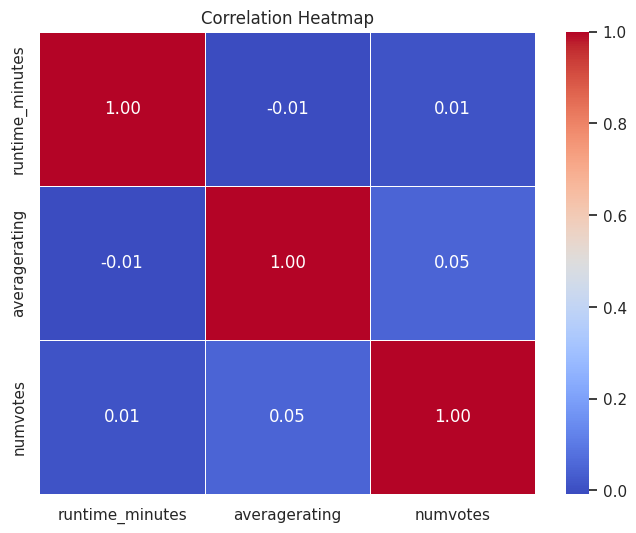

In [586]:
import seaborn as sns
correlation = merged_df[['runtime_minutes', 'averagerating', 'numvotes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [587]:
import pandas as pd

# Make sure 'genres' are treated as a list of genres
merged_df['genres'] = merged_df['genres'].fillna('').astype(str)

# Split the genres in each row into individual genres
merged_df['genres'] = merged_df['genres'].str.split(',')

# Explode the genres column to create a new row for each genre
exploded_df = merged_df.explode('genres')

# Group by 'genres' and calculate the average rating
genre_avg_rating = exploded_df.groupby('genres')['averagerating'].mean().reset_index()

# Sort by average rating in descending order for better clarity
genre_avg_rating = genre_avg_rating.sort_values(by='averagerating', ascending=False)

# Display the result
print(genre_avg_rating)


         genres  averagerating
21        Short       8.800000
7   Documentary       7.316787
11    Game-Show       7.300000
17         News       7.278783
4     Biography       7.169185
14        Music       7.070662
12      History       7.048928
22        Sport       6.964604
18   Reality-TV       6.600000
25          War       6.573962
15      Musical       6.524451
24      Unknown       6.452132
9        Family       6.401362
8         Drama       6.391692
3     Animation       6.250836
2     Adventure       6.178873
19      Romance       6.148059
6         Crime       6.110742
5        Comedy       6.014110
10      Fantasy       5.894413
16      Mystery       5.891346
26      Western       5.824219
0        Action       5.784437
23     Thriller       5.592140
20       Sci-Fi       5.431494
13       Horror       4.934538
1         Adult       3.950000


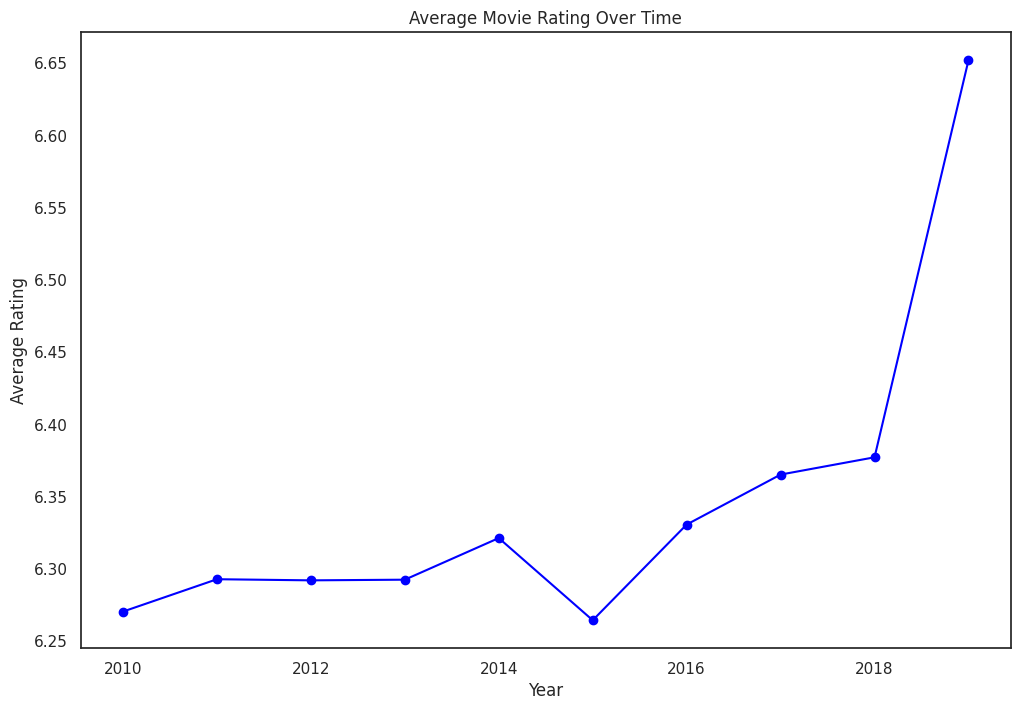

In [588]:
avg_rating_per_year = merged_df.groupby('start_year')['averagerating'].mean()
avg_rating_per_year.plot(kind='line', figsize=(12, 8), color='blue', marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating Over Time')
plt.show()


There seems to be a steady increase in movie ratings over the years which could be caused by higher movie budgets and improvement if technology in the film industry.

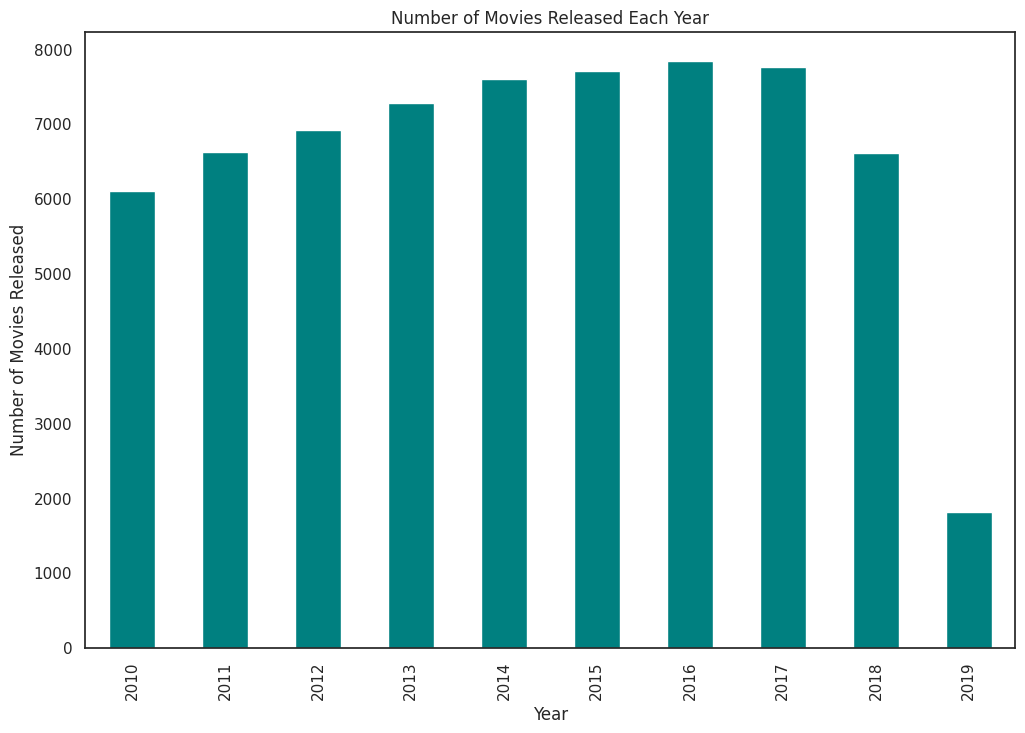

In [589]:
movie_count_per_year = merged_df.groupby('start_year').size()
movie_count_per_year.plot(kind='bar', figsize=(12, 8), color='teal')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')
plt.xticks(rotation=90)
plt.show()


There seems to be a steady increase in the number of movies released with the exception of 2018

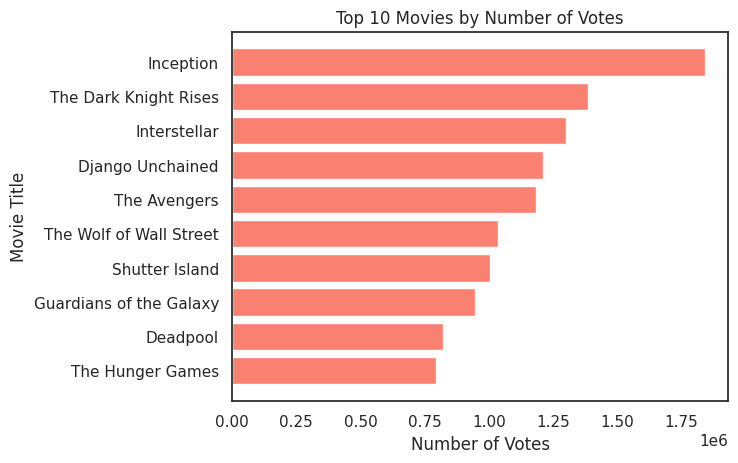

In [590]:
top_voted_movies = merged_df.nlargest(10, 'numvotes')
plt.barh(top_voted_movies['primary_title'], top_voted_movies['numvotes'], color='salmon')
plt.xlabel('Number of Votes')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Number of Votes')
plt.gca().invert_yaxis()
plt.show()


Action movies seem to have the most amount of votes showing higher engagement from users

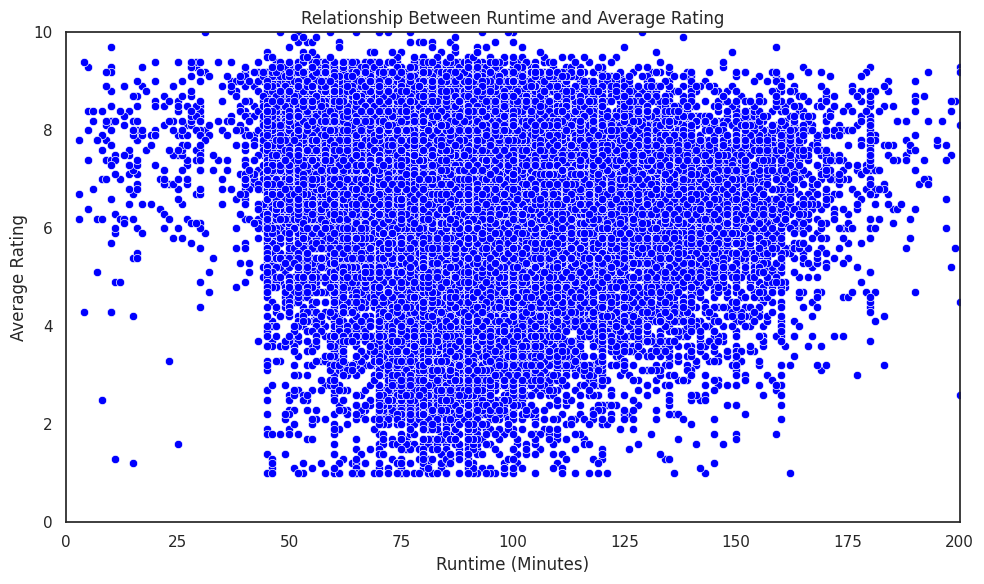

In [591]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows where 'runtime_minutes' or 'averagerating' is NaN
merged_df_clean = merged_df.dropna(subset=['runtime_minutes', 'averagerating'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_clean, x='runtime_minutes', y='averagerating', color='blue')

# Set plot labels and title
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Average Rating')
plt.title('Relationship Between Runtime and Average Rating')

# Set x-axis limits from 0 to 200 minutes
plt.xlim(0, 200)

# Set y-axis scale from 0 to 10
plt.ylim(0, 10)

# Show the plot
plt.tight_layout()
plt.show()


In [592]:
import pandas as pd

# Drop rows where 'runtime_minutes' or 'averagerating' is NaN
merged_df_clean = merged_df.dropna(subset=['runtime_minutes', 'averagerating'])

# Create runtime bins of 20 minutes
bins = range(0, int(merged_df_clean['runtime_minutes'].max()) + 20, 20)
labels = [f"{i}-{i+19}" for i in bins[:-1]]

# Add a new column for runtime bins
merged_df_clean['runtime_bins'] = pd.cut(merged_df_clean['runtime_minutes'], bins=bins, labels=labels, right=False)

# Group by runtime bins and calculate the average rating
runtime_avg_rating = merged_df_clean.groupby('runtime_bins')['averagerating'].mean().reset_index()

# Find the bin with the highest average rating
max_rating_bin = runtime_avg_rating[runtime_avg_rating['averagerating'] == runtime_avg_rating['averagerating'].max()]

# Output the result
max_rating_bin


runtime_bins  averagerating
19      380-399            9.2

Movies with runtimes between 380-400 minutes tend to have better ratings and higher audience engagement.

### The Numbers Data

In [593]:
# Summary statistics for columns production budget, domestic gross and worldwide gross
df[['production_budget', 'domestic_gross', 'worldwide_gross']].describe()

production_budget  domestic_gross  worldwide_gross
count       5.782000e+03    5.782000e+03     5.782000e+03
mean        3.158776e+07    4.187333e+07     9.148746e+07
std         4.181208e+07    6.824060e+07     1.747200e+08
min         1.100000e+03    0.000000e+00     0.000000e+00
25%         5.000000e+06    1.429534e+06     4.125415e+06
50%         1.700000e+07    1.722594e+07     2.798445e+07
75%         4.000000e+07    5.234866e+07     9.764584e+07
max         4.250000e+08    9.366622e+08     2.776345e+09

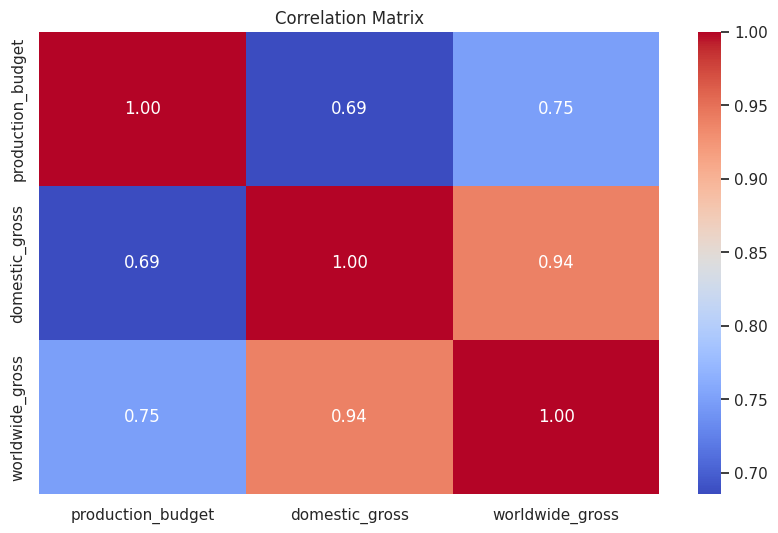

In [594]:
#Visualisation
#correlation matrix
correlation_matrix = df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


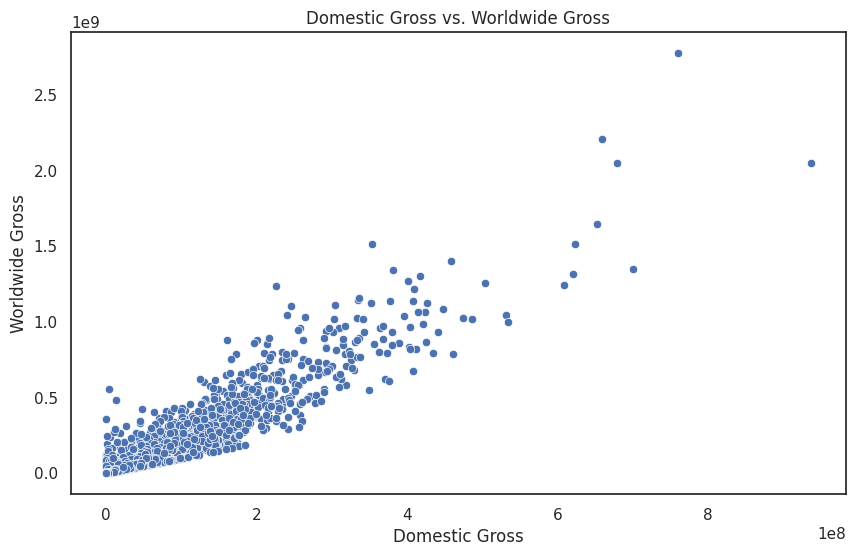

In [595]:
#a scatter plot to show the relationship between domestic and worldwide gross
plt.figure(figsize=(10, 6))
sns.scatterplot(x='domestic_gross', y='worldwide_gross', data=df)
plt.xlabel('Domestic Gross')
plt.ylabel('Worldwide Gross')
plt.title('Domestic Gross vs. Worldwide Gross')
plt.show()

In [596]:
#removing outliers on domestic and worldwide gross using percentiles
#define percentiles
lower_percentile = 0.01
upper_percentile = 0.99

#calculate the threshold values
lower_threshold = df['domestic_gross'].quantile(lower_percentile)
upper_threshold = df['domestic_gross'].quantile(upper_percentile)

lower_threshold_worldwide = df['worldwide_gross'].quantile(lower_percentile)
upper_threshold_worldwide = df['worldwide_gross'].quantile(upper_percentile)

lower_threshold_budget = df['production_budget'].quantile(lower_percentile)
upper_threshold_budget = df['production_budget'].quantile(upper_percentile)

#filter rows where values are outside the bounds
df_cleaned = df[(df['domestic_gross'] >= lower_threshold) & (df['domestic_gross'] <= upper_threshold)]
df_cleaned = df_cleaned[(df_cleaned['worldwide_gross'] >= lower_threshold_worldwide) & (df_cleaned['worldwide_gross'] <= upper_threshold_worldwide)]
df_cleaned = df_cleaned[(df_cleaned['production_budget'] >= lower_threshold_budget) & (df_cleaned['production_budget'] <= upper_threshold_budget)]

#print the cleaned dataset
print("Original dataset size:", df.shape)
print("Cleaned dataset size:", df_cleaned.shape)


Original dataset size: (5782, 6)
Cleaned dataset size: (5631, 6)


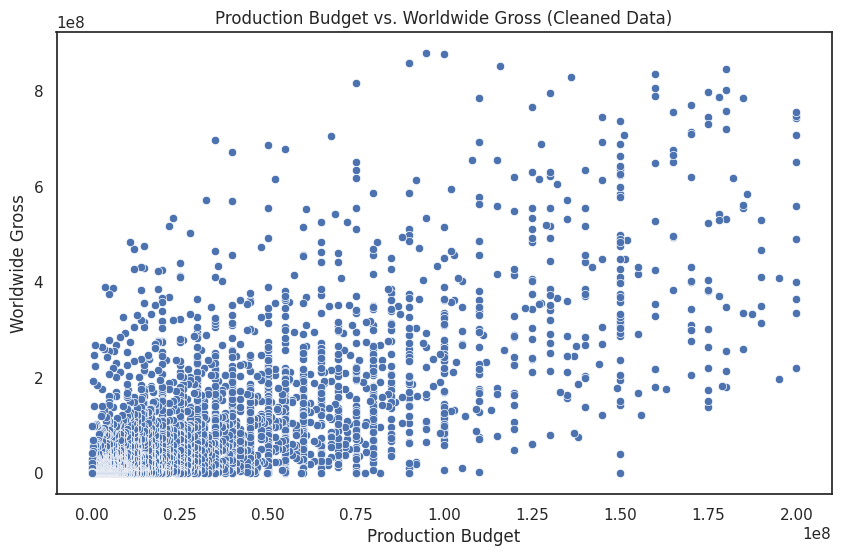

In [597]:
#plotting scatter plot for production budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x='production_budget', y='worldwide_gross', data=df_cleaned)
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross (Cleaned Data)')
plt.show()


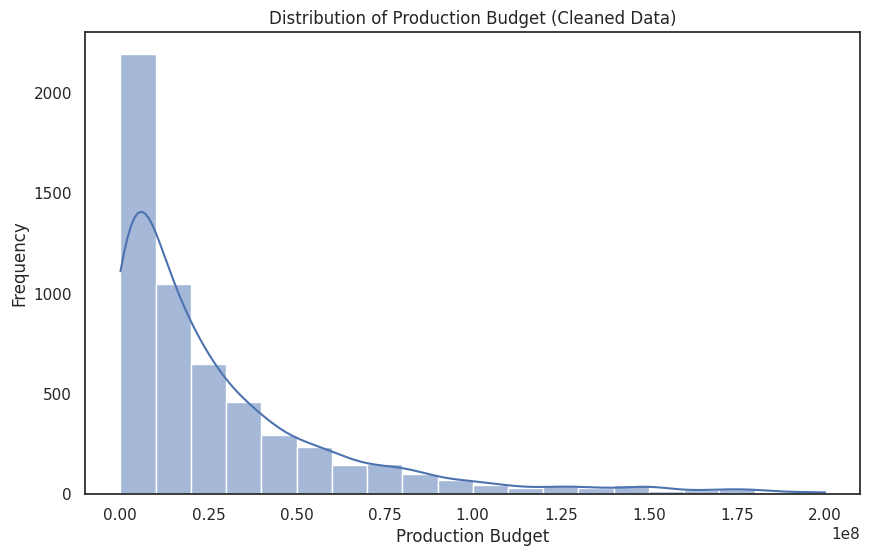

In [598]:
#plotting a histogram for production budget
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['production_budget'], bins=20, kde=True)
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.title('Distribution of Production Budget (Cleaned Data)')
plt.show()


## Hypothesis testing
Null hypothesis-There is no significant relationship between production budgets and worldwide gross revenue.

Alternate hypothesis-Higher production budgets lead to higher worldwide gross revenue.

In [599]:
# Using Pearson correlation
from scipy.stats import pearsonr

# Calculate correlation
correlation, p_value = pearsonr(df_cleaned['production_budget'], df_cleaned['worldwide_gross'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


Correlation coefficient: 0.7192765756414683
P-value: 0.0


A correlation coefficient of 0.75 suggests a strong positive correlation between production budget and worldwide gross.This means movies with higher production budgets tend to earn more in worldwide gross revenue.


A p value of 0.0 indicates that the relationship between production budgets and worldwide gross revenue is statistically significant.


Conclusion:Reject the null hypothesis.
There is a significant relationship between the production budgets and worldwide gross revenue.

In [600]:
#predicting worldwide gross using production budget
#import libraries
import statsmodels.api as sm

#define the independent and dependent variable
X = df_cleaned['production_budget']
y = df_cleaned['worldwide_gross']

#add a constant to the independent variable
X = sm.add_constant(X)

#fit the linear regression model
model = sm.OLS(y, X).fit()

#print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     6034.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        08:13:11   Log-Likelihood:            -1.1091e+05
No. Observations:                5631   AIC:                         2.218e+05
Df Residuals:                    5629   BIC:                         2.218e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.554e+06    1.5e+0

##### Model Evaluation
R-Squared: About 51.7% of the variance in worldwide gross is explained by the production budget.

Coefficient: For every unit increase in production budget, worldwide gross increases by an average of 2.53.

P-Value: The p-value is 0.00, which is less than 0.05. This shows that the model is statistically significant and the production budget has a meaningful impact on worldwide gross.

F-Statistic: The F-statistic (6034) confirms that the model as a whole is statistically significant, meaning that production budget significantly explains worldwide gross.

In [601]:
#extracting the intercept
intercept = model.params['const']
print(f"Intercept: (Constant) {intercept}")

Intercept: (Constant) 3553931.6418457422


In [602]:
#extracting the slope
slope = model.params['production_budget']
print(f"Slope: (Coefficient) {slope}")

Slope: (Coefficient) 2.531649874719684


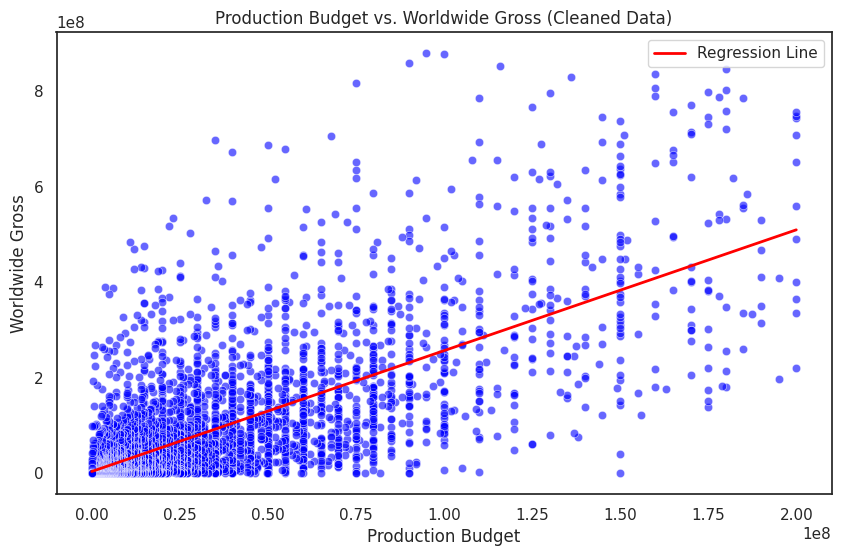

In [603]:
#Visualization using linear regression
plt.figure(figsize=(10, 6))

# Scatter plot for the cleaned data
sns.scatterplot(x='production_budget', y='worldwide_gross', data=df_cleaned, color='blue', alpha=0.6)
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross (Cleaned Data)')

# Define independent and dependent variables
X_cleaned = sm.add_constant(df_cleaned['production_budget'])
y_cleaned = df_cleaned['worldwide_gross']

# Fit the linear regression model
model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()

# Add regression line
plt.plot(df_cleaned['production_budget'], model_cleaned.predict(X_cleaned), color='red', linewidth=2, label='Regression Line')

plt.legend()
plt.show()



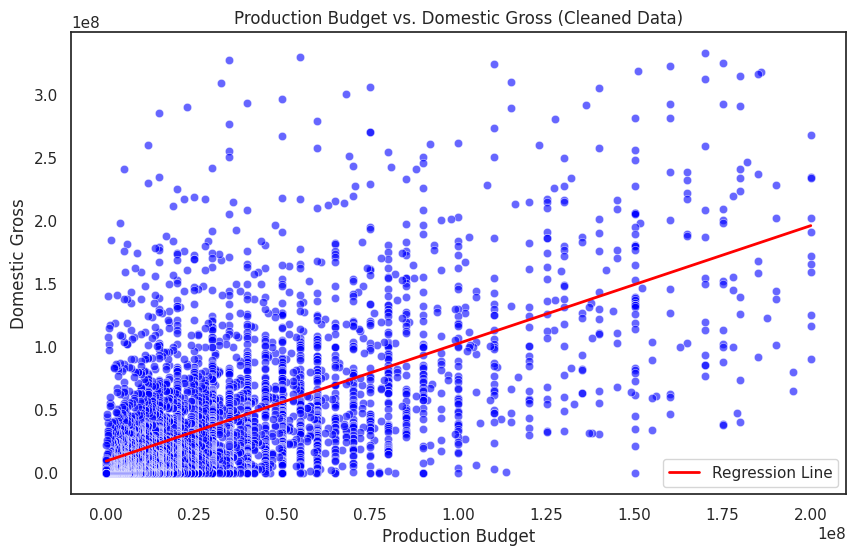

In [604]:
#plotting linear regression of domestic gross and production budget
plt.figure(figsize=(10, 6))

# Scatter plot for the cleaned data
sns.scatterplot(x='production_budget', y='domestic_gross', data=df_cleaned, color='blue', alpha=0.6)
plt.xlabel('Production Budget')
plt.ylabel('Domestic Gross')
plt.title('Production Budget vs. Domestic Gross (Cleaned Data)')

# Define independent and dependent variables
X_cleaned = sm.add_constant(df_cleaned['production_budget'])  # Add constant for regression
y_cleaned = df_cleaned['domestic_gross']

# Fit the linear regression model
model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()

# Add regression line
plt.plot(df_cleaned['production_budget'], model_cleaned.predict(X_cleaned), color='red', linewidth=2, label='Regression Line')

plt.legend()
plt.show()


In [605]:
#defining variables
X = df_cleaned[['production_budget', 'domestic_gross']]
y = df_cleaned['worldwide_gross']

#add a constant to the independent variable
X = sm.add_constant(X)

#fit the multiple linear regression model
model_cleaned = sm.OLS(y, X).fit()

#print the summary of the model
print(model_cleaned.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 1.959e+04
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        08:13:13   Log-Likelihood:            -1.0712e+05
No. Observations:                5631   AIC:                         2.143e+05
Df Residuals:                    5628   BIC:                         2.143e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.452e+07   7.78e+0

R-Squared:87.4% of the variance in worldwide gross is explained by the production budget and domestic gross. This indicates that the model fits the data well.

Coefficients:

For every unit increase in production budget, worldwide gross increases by an average of 0.77, holding domestic gross constant. For every unit increase in domestic gross, worldwide gross increases by an average of 1.88, holding production budget constant.

P-Values: The p-values for both predictors are 0.00, indicating that they are statistically significant contributors to worldwide gross.

F-Statistic: The F-statistic 19,590 confirms that the overall model is statistically significant

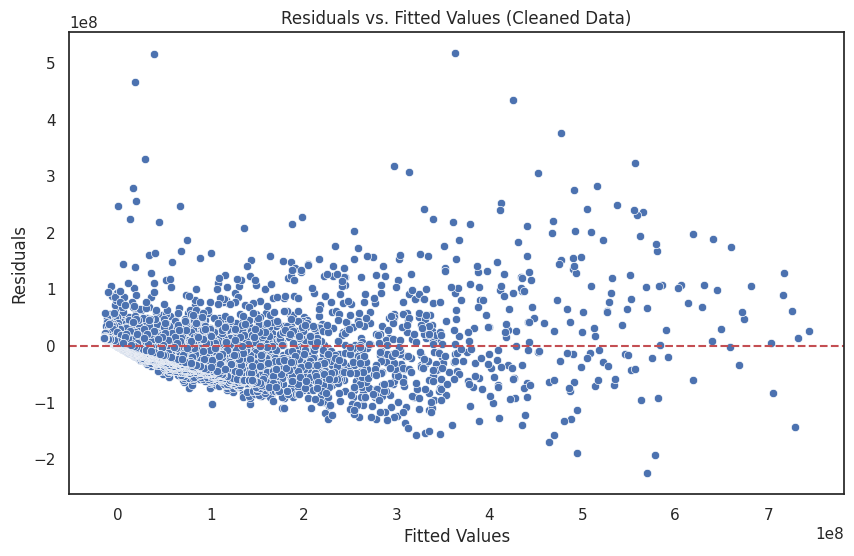

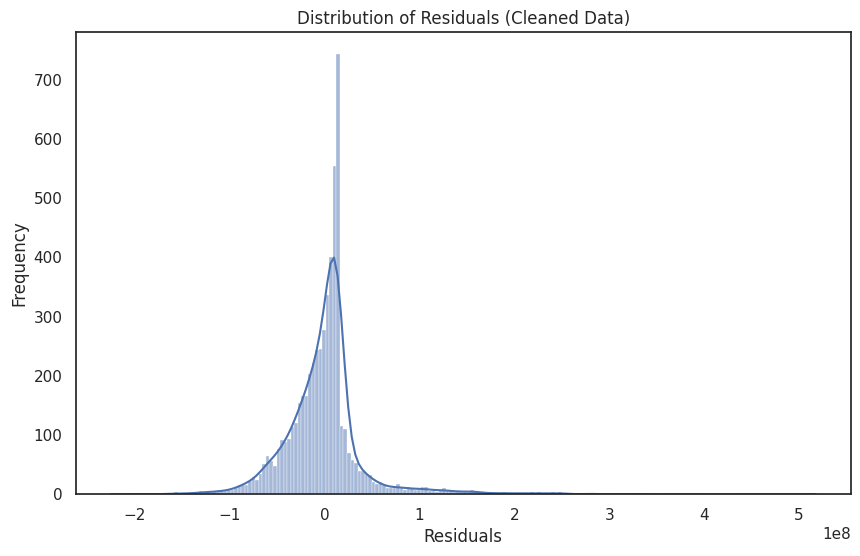

In [606]:
#plot residuals using fitted values
residuals = model_cleaned.resid
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model_cleaned.fittedvalues, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values (Cleaned Data)')
plt.show()

#histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Cleaned Data)')
plt.show()


## Box Office Mojo Data

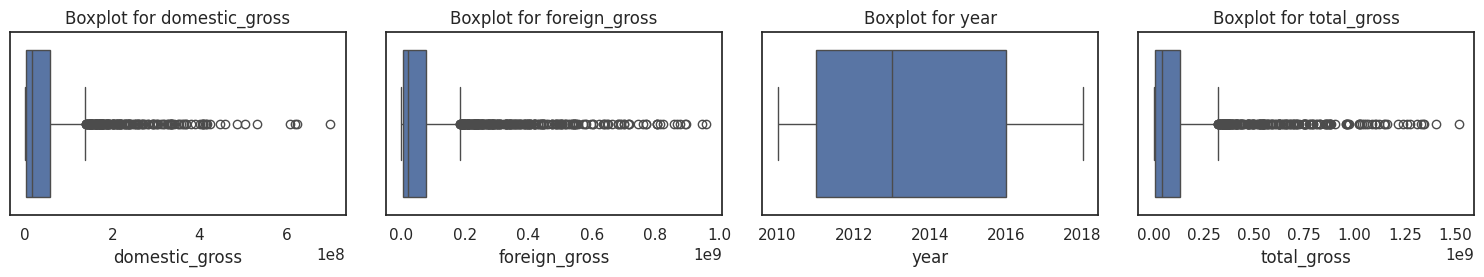

In [607]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create box plots for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)  # Adjust the grid size if you have more than 16 features
    sns.boxplot(x=bom_clean[column])
    plt.title(f'Boxplot for {column}')
plt.tight_layout()
plt.show()

In [608]:
# Defining a function to cap the outliers.

def cap_outliers(bom_clean, column, lower_percentile=0.01, upper_percentile=0.99):
    for col in column:
        lower_cap = bom_clean[col].quantile(lower_percentile)  # 1st percentile
        upper_cap = bom_clean[col].quantile(upper_percentile)  # 99th percentile
        bom_clean[col] = bom_clean[col].clip(lower=lower_cap, upper=upper_cap)
    return bom_clean

# List of features to apply capping
column_to_cap = ['domestic_gross','foreign_gross','total_gross']

# Apply capping
bom_clean= cap_outliers(bom_clean, column_to_cap)

# Check if capping was applied successfully
print(bom_clean[column_to_cap].describe(percentiles=[0.01, 0.99]))


       domestic_gross  foreign_gross   total_gross
count    2.002000e+03   2.002000e+03  2.002000e+03
mean     4.467382e+07   7.485974e+07  1.198928e+08
std      7.049709e+07   1.324566e+08  1.968330e+08
min      3.201000e+03   1.270500e+04  5.566900e+04
1%       3.201990e+03   1.270995e+04  5.573731e+04
50%      1.640000e+07   1.960000e+07  4.220000e+07
99%      3.683940e+08   6.998269e+08  1.034677e+09
max      3.683970e+08   6.999130e+08  1.034738e+09


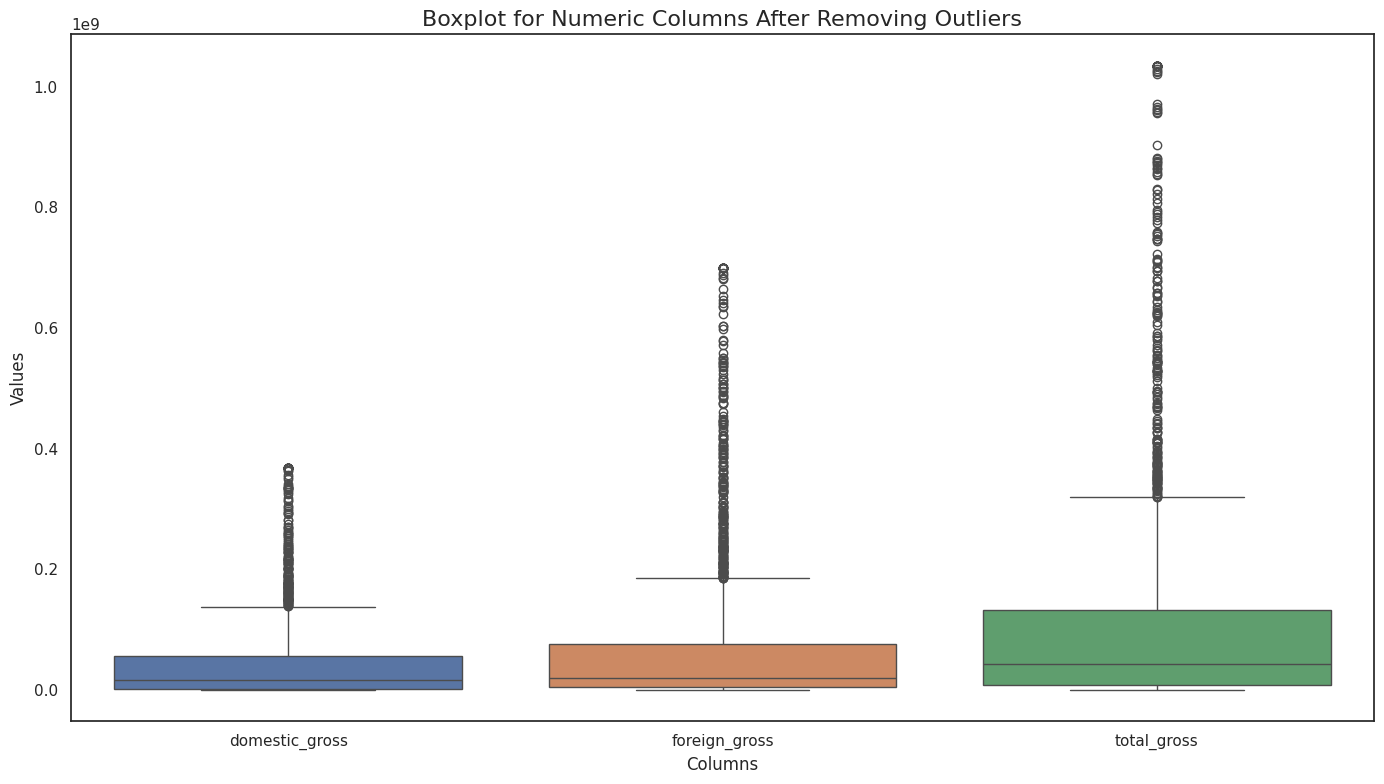

In [609]:
# Define the numeric columns you want to plot
numeric_columns = ['domestic_gross','foreign_gross','total_gross']
# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the boxplot using Seaborn
sns.boxplot(data=bom_clean[numeric_columns])

# Add title and labels
plt.title('Boxplot for Numeric Columns After Removing Outliers', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

 Check for inconsistent categories in the categorical columns inorder to standardize the categorical labels.

In [610]:
# Check for the categorical columns.
categorical_columns = bom_clean.select_dtypes(include=['object', 'category']).columns
print(f"The categorical columns include: {categorical_columns}")

The categorical columns include: Index(['movie title', 'studio'], dtype='object')


In [611]:
# List of the categorical columns in the dataset
categorical_columns = ['movie title','studio']

# Check the Unique Values using for loops in order to identify inconsistencies or unusual categories in the dataset.
for column in categorical_columns:
    print(f"Unique values in '{column}':\n{bom_clean[column].unique()}\n")

Unique values in 'movie title':
['Toy Story 3' 'Alice in Wonderland (2010)'
 'Harry Potter and the Deathly Hallows Part 1' ... 'Time Freak'
 'Reign of Judges: Title of Liberty - Concept Short'
 'Antonio Lopez 1970: Sex Fashion & Disco']

Unique values in 'studio':
['BV' 'WB' 'P/DW' 'Sum.' 'Par.' 'Uni.' 'Fox' 'Wein.' 'Sony' 'FoxS' 'SGem'
 'WB (NL)' 'LGF' 'MBox' 'CL' 'W/Dim.' 'CBS' 'Focus' 'MGM' 'Over.' 'Mira.'
 'IFC' 'CJ' 'NM' 'SPC' 'ParV' 'Gold.' 'JS' 'RAtt.' 'Magn.' 'Free' '3D'
 'UTV' 'Rela.' 'Zeit.' 'Anch.' 'PDA' 'Lorb.' 'App.' 'Drft.' 'Osci.' 'IW'
 'Rog.' 'Eros' 'Relbig.' 'Viv.' 'Hann.' 'Strand' 'NGE' 'Scre.' 'Kino'
 'Abr.' 'CZ' 'ATO' 'First' 'GK' 'FInd.' 'NFC' 'TFC' 'Pala.' 'Imag.' 'NAV'
 'Arth.' 'CLS' 'Mont.' 'Olive' 'CGld' 'FOAK' 'IVP' 'Yash' 'ICir' 'WOW'
 'FM' 'FD' 'Vari.' 'TriS' 'ORF' 'IM' 'Elev.' 'Cohen' 'NeoC' 'Jan.' 'MNE'
 'Trib.' 'Vita.' 'Rocket' 'OMNI/FSR' 'KKM' 'Argo.' 'Libre' 'FRun' 'P4'
 'KC' 'MPFT' 'Icar.' 'AGF' 'NYer' 'LG/S' 'WHE' 'WGUSA' 'MPI' 'RTWC' 'FIP'
 'RF' 'KL'

In [612]:
# Handling Rare Categories.
# Check frequency distribution and handle rare values for  'studio'
for column in [ 'studio']:
    print(f"Value counts in '{column}':\n{bom_clean[column].value_counts()}\n")
    # Example threshold: Categories with less than 5 occurrences
    category_counts = bom_clean[column].value_counts()
    rare_categories = category_counts[category_counts < 5].index
    bom_clean[column] = bom_clean[column].replace(rare_categories, 'other')

    # Re-check unique values after handling rare categories
    print(f"Unique values in '{column}' after handling rare categories:\n{bom_clean[column].unique()}\n")

Value counts in 'studio':
studio
Uni.            141
Fox             134
WB              130
Sony            105
BV              102
               ... 
AGF               1
Icar.             1
MPFT              1
KC                1
Darin Southa      1
Name: count, Length: 172, dtype: int64

Unique values in 'studio' after handling rare categories:
['BV' 'WB' 'P/DW' 'Sum.' 'Par.' 'Uni.' 'Fox' 'Wein.' 'Sony' 'FoxS' 'SGem'
 'WB (NL)' 'LGF' 'MBox' 'CL' 'W/Dim.' 'CBS' 'Focus' 'other' 'Over.' 'IFC'
 'CJ' 'SPC' 'Gold.' 'RAtt.' 'Magn.' 'Free' 'UTV' 'Rela.' 'Zeit.' 'Anch.'
 'Lorb.' 'Drft.' 'Osci.' 'Eros' 'Strand' 'NGE' 'Kino' 'GK' 'Yash' 'FM'
 'FD' 'Vari.' 'TriS' 'ORF' 'Elev.' 'Cohen' 'MNE' 'FRun' 'LG/S' 'WGUSA'
 'RTWC' 'FIP' 'KL' 'EOne' 'A24' 'STX' 'BST' 'Amazon' 'Annapurna']



In [613]:
# We can use the str.strip function on colunms to strip the leading and trailing spaces
bom_clean.columns=bom_clean.columns.str.strip()


In [614]:
# Aggregate analysis
movie_title_counts = bom_clean['movie title'].value_counts().head(10)
movie_title_counts

movie title
Toy Story 3                         1
Insidious Chapter 3                 1
Poltergeist (2015)                  1
Spotlight                           1
The Visit                           1
Devil and Angel (E Gun Tian Shi)    1
Black Mass                          1
Joy                                 1
Chappie                             1
Vacation                            1
Name: count, dtype: int64

In [615]:
domestic_gross_counts= bom_clean['domestic_gross'].value_counts().head(10)
domestic_gross_counts

domestic_gross
368397000.0    21
3201.0         21
1500000.0      14
1000000.0      13
1300000.0      12
1100000.0      11
2000000.0      10
1600000.0      10
1400000.0      10
2600000.0       8
Name: count, dtype: int64

In [616]:
foreign_gross_counts= bom_clean['foreign_gross'].value_counts().head(10)
foreign_gross_counts

foreign_gross
1200000.0      23
699913000.0    21
12705.0        21
1100000.0      13
4200000.0      12
2500000.0      11
1900000.0      11
1300000.0      10
2000000.0      10
2600000.0      10
Name: count, dtype: int64

In [617]:
studio_counts= bom_clean['studio'].value_counts().head(10)
studio_counts

studio
other    186
Uni.     141
Fox      134
WB       130
Sony     105
BV       102
Par.      94
LGF       87
Wein.     69
IFC       68
Name: count, dtype: int64

In [618]:
year_counts= bom_clean['year'].value_counts().head(10)
year_counts

year
2010    308
2011    290
2012    243
2014    234
2013    200
2016    192
2015    187
2017    176
2018    172
Name: count, dtype: int64

In [619]:
total_gross_counts= bom_clean['total_gross'].value_counts().head(10)
total_gross_counts

total_gross
1.034738e+09    21
5.566900e+04    21
7.900000e+06     5
1.690000e+07     5
1.540000e+07     5
2.740000e+07     5
5.500000e+06     4
1.960000e+07     4
1.310000e+07     4
9.100000e+06     4
Name: count, dtype: int64

Calculate the mean, median and standard deviation for the following numerical columns: 'domestic_gross','foreign_gross', 'year', 'total_gross'

In [620]:
mean_domestic_gross = bom_clean['domestic_gross'].mean()
mean_domestic_gross

44673820.98201798

In [621]:
median_domestic_gross = bom_clean['domestic_gross'].median()
median_domestic_gross

16399999.0

In [622]:
std_domestic_gross = bom_clean['domestic_gross'].std()
std_domestic_gross

70497094.39806506

In [623]:
mean_year= bom_clean['year'].mean()
mean_year

2013.5

In [624]:
median_year= bom_clean['year'].median()
median_year

2013.0

In [625]:
std_year= bom_clean['year'].std()
std_year

2.5974750358221232

In [626]:
mean_foreign_gross = bom_clean['foreign_gross'].mean()
mean_foreign_gross

74859735.95804195

In [627]:
median_foreign_gross = bom_clean['foreign_gross'].median()
median_foreign_gross

19600000.0

In [628]:
std_foreign_gross = bom_clean['foreign_gross'].std()
std_foreign_gross

132456638.62469716

In [629]:
mean_total_gross = bom_clean['total_gross'].mean()
mean_total_gross

119892831.17732267

In [630]:
median_total_gross = bom_clean['total_gross'].median()
median_total_gross

42200000.0

In [631]:
std_foreign_gross = bom_clean['total_gross'].std()
std_foreign_gross

196832951.3271825

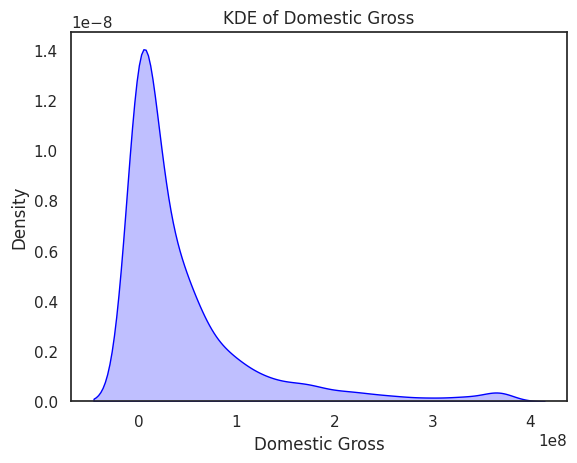

In [632]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot KDE for 'domestic_gross'
sns.kdeplot(data=bom_clean, x='domestic_gross', fill=True, color='blue')
plt.title('KDE of Domestic Gross')
plt.xlabel('Domestic Gross')
plt.ylabel('Density')
plt.show()

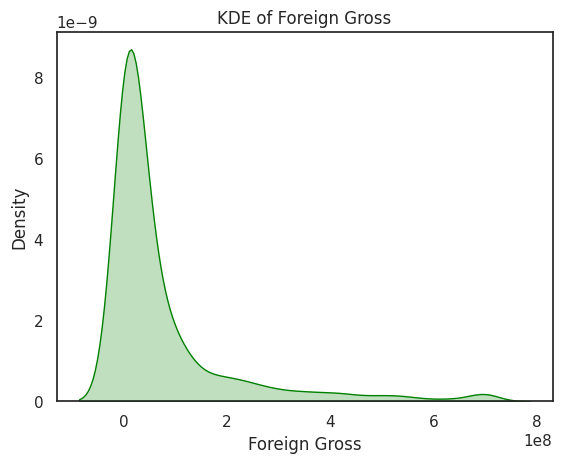

In [633]:
# Plot KDE for 'Foreign_gross'
sns.kdeplot(data=bom_clean, x='foreign_gross', fill=True, color='green')
plt.title('KDE of Foreign Gross')
plt.xlabel('Foreign Gross')
plt.ylabel('Density')
plt.show()

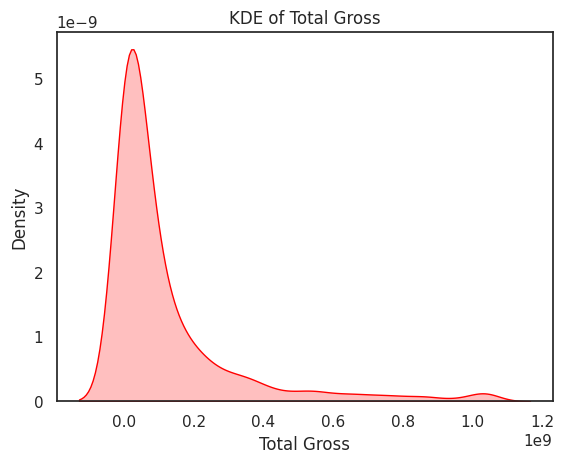

In [634]:
# Plot KDE for 'total_gross'
sns.kdeplot(data=bom_clean, x='total_gross', fill=True, color='red')
plt.title('KDE of Total Gross')
plt.xlabel('Total Gross')
plt.ylabel('Density')
plt.show()

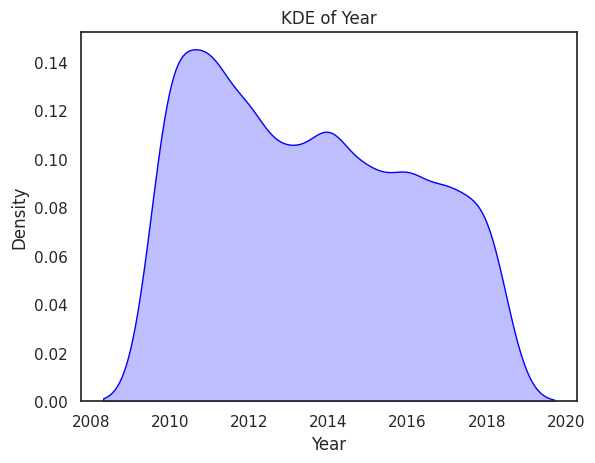

In [635]:
# Plot KDE for 'year'
sns.kdeplot(data=bom_clean, x='year', fill=True, color='blue')
plt.title('KDE of Year')
plt.xlabel('Year')
plt.ylabel('Density')
plt.show()

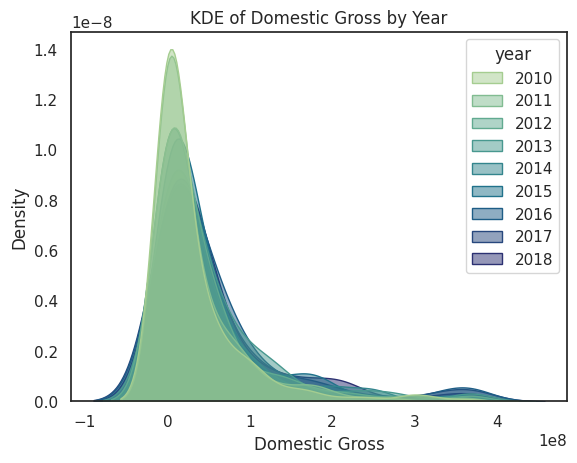

In [636]:
# KDE plot for comparing domestic gross vs year.
sns.kdeplot(data=bom_clean, x='domestic_gross', hue='year', fill=True, common_norm=False, alpha=0.5, palette='crest')
plt.title('KDE of Domestic Gross by Year')
plt.xlabel('Domestic Gross')
plt.ylabel('Density')
plt.show()

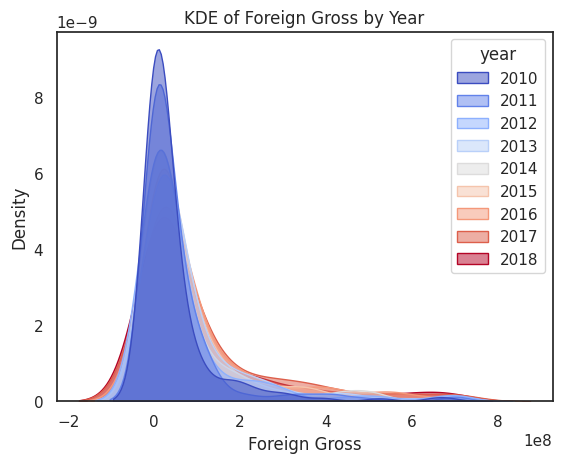

In [637]:
# KDE plot for comparing foreign gross vs year.
sns.kdeplot(data=bom_clean, x='foreign_gross', hue='year', fill=True, common_norm=False, alpha=0.5, palette='coolwarm')
plt.title('KDE of Foreign Gross by Year')
plt.xlabel('Foreign Gross')
plt.ylabel('Density')
plt.show()

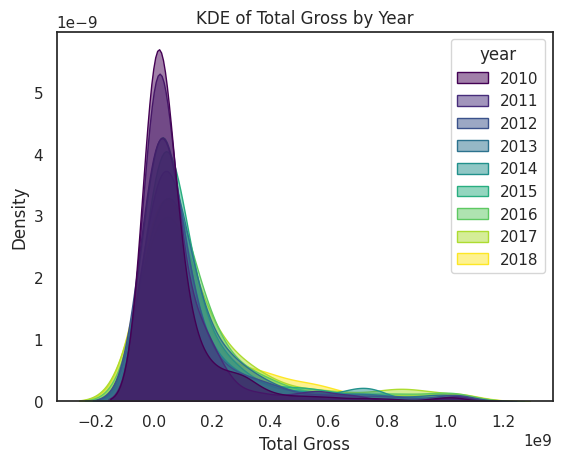

In [638]:
# KDE plot for comparing total gross vs year.
sns.kdeplot(data=bom_clean, x='total_gross', hue='year', fill=True, common_norm=False, alpha=0.5, palette='viridis')
plt.title('KDE of Total Gross by Year')
plt.xlabel('Total Gross')
plt.ylabel('Density')
plt.show()

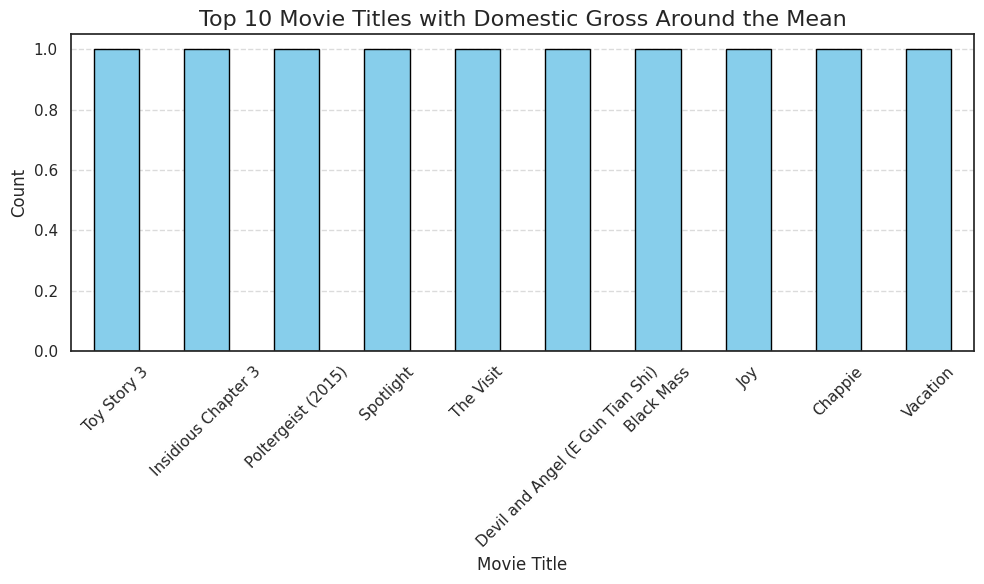

In [639]:
# Calculate the mean domestic gross.
mean_domestic_gross = bom_clean['domestic_gross'].mean()

movie_title_counts = bom_clean['movie title'].value_counts().head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
movie_title_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Movie Titles with Domestic Gross Around the Mean', fontsize=16)
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

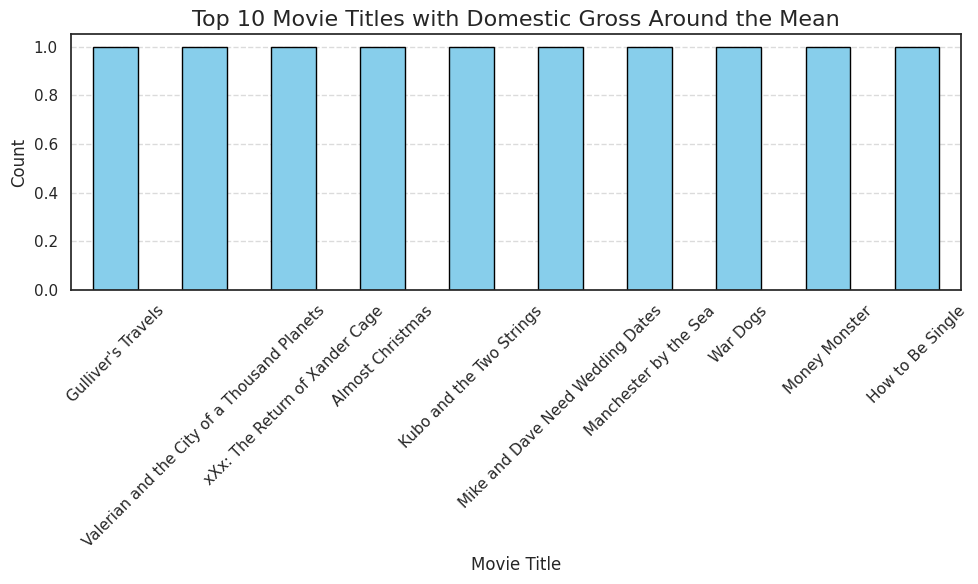

In [640]:
# Refined code  with filtered rows where domestic gross is close to mean.
# Calculate the mean domestic gross
mean_domestic_gross = bom_clean['domestic_gross'].mean()

# Filter the rows where domestic_gross is close to the mean
threshold = 0.1  # This is the 10% threshold around the mean
filtered_bom = bom_clean[
    (bom_clean['domestic_gross'] >= mean_domestic_gross * (1 - threshold)) &
    (bom_clean['domestic_gross'] <= mean_domestic_gross * (1 + threshold))
]

# The top 10 movie titles based on filtered data
movie_title_counts = filtered_bom['movie title'].value_counts().head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
movie_title_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Movie Titles with Domestic Gross Around the Mean', fontsize=16)
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



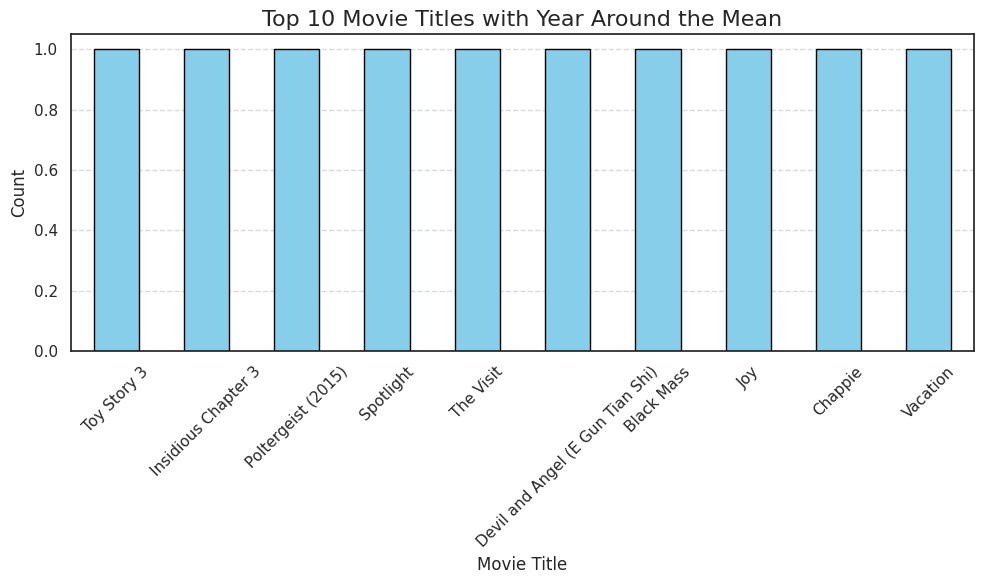

In [641]:
# Calculate the mean domestic gross.
mean_year = bom_clean['year'].mean()

movie_title_counts = bom_clean['movie title'].value_counts().head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
movie_title_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Movie Titles with Year Around the Mean', fontsize=16)
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

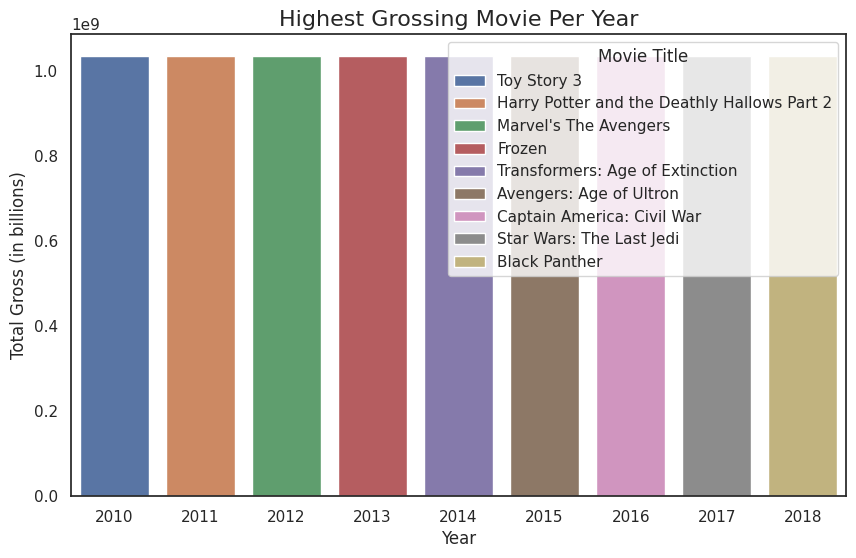

In [642]:

# Find the movie with the highest gross per year
highest_gross_per_year = bom_clean.loc[bom_clean.groupby('year')['total_gross'].idxmax()]

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=highest_gross_per_year,
    x='year',
    y='total_gross',
    hue='movie title',
    dodge=False
)
plt.title('Highest Grossing Movie Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Gross (in billions)', fontsize=12)
plt.legend(title='Movie Title')
plt.show()


The highest grossing movie per year from 2010-2018 as follows:  
* 2010: Toy story 3
* 2011: Harry Potter and the Deathly Hallows part 2
* 2012: Marvel's the Avengers
* 2013: Frozen
* 2014: Transformers: Age of Extinction
* 2015: Avengers: A ge of Ultron
* 2016: Captain America: Civil War
* 2017: Star Wars: The Last Jedi
* 2018: Black Panther

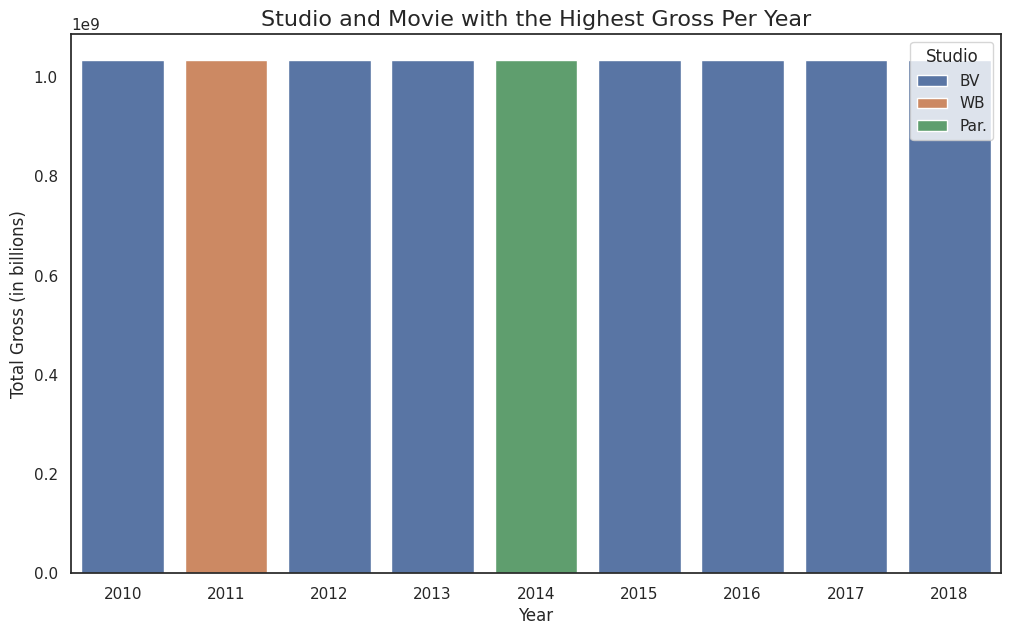

      year studio                                  movie title   total_gross
0     2010     BV                                  Toy Story 3  1.034738e+09
328   2011     WB  Harry Potter and the Deathly Hallows Part 2  1.034738e+09
727   2012     BV                        Marvel's The Avengers  1.034738e+09
1127  2013     BV                                       Frozen  1.034738e+09
1477  2014   Par.              Transformers: Age of Extinction  1.034738e+09
1875  2015     BV                      Avengers: Age of Ultron  1.034738e+09
2322  2016     BV                   Captain America: Civil War  1.034738e+09
2758  2017     BV                     Star Wars: The Last Jedi  1.034738e+09
3080  2018     BV                                Black Panther  1.034738e+09


In [643]:

# Find the movie and studio with the highest gross per year
highest_gross_per_year = bom_clean.loc[bom_clean.groupby('year')['total_gross'].idxmax()]

# Plot using seaborn
plt.figure(figsize=(12, 7))
sns.barplot(
    data=highest_gross_per_year,
    x='year',
    y='total_gross',
    hue='studio',
    dodge=False
)
plt.title('Studio and Movie with the Highest Gross Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Gross (in billions)', fontsize=12)
plt.legend(title='Studio')
plt.show()

# Print the highest-grossing movie and studio per year for reference
print(highest_gross_per_year[['year', 'studio', 'movie title', 'total_gross']])


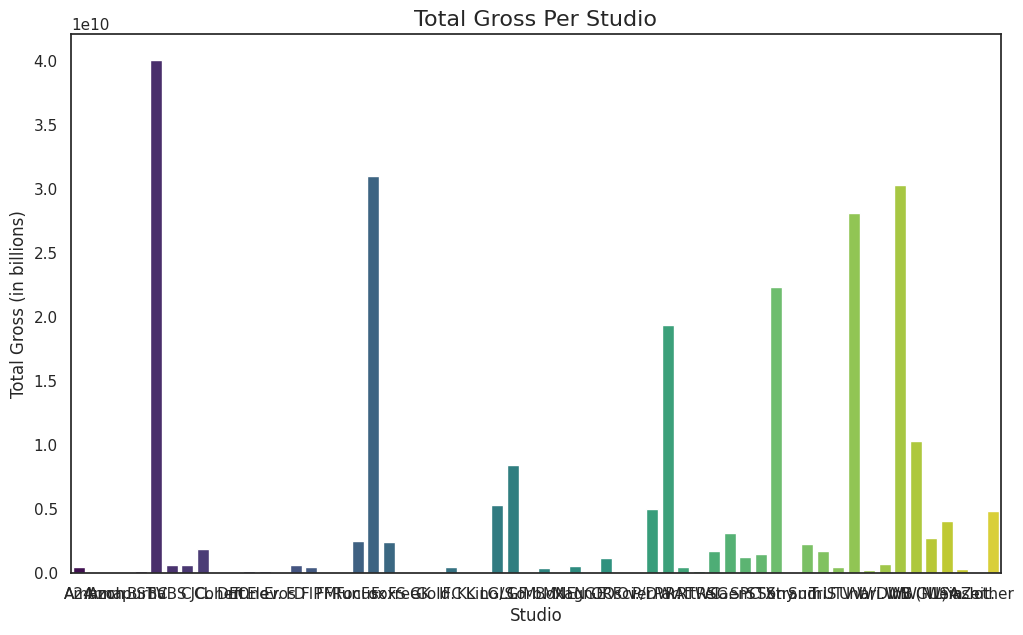

Highest-grossing movie and studio overall:
movie title        Toy Story 3
studio                      BV
domestic_gross     368397000.0
foreign_gross      652000000.0
year                      2010
total_gross       1034738000.0
Name: 0, dtype: object


In [644]:

# Find the movie and studio with the highest gross overall
highest_gross_overall = bom_clean.loc[bom_clean['total_gross'].idxmax()]

# Summarize the total gross per studio
total_gross_per_studio = bom_clean.groupby('studio')['total_gross'].sum().reset_index()

# Plot total gross per studio
plt.figure(figsize=(12, 7))
sns.barplot(
    data=total_gross_per_studio,
    x='studio',
    y='total_gross',
    palette='viridis'
)
plt.title('Total Gross Per Studio', fontsize=16)
plt.xlabel('Studio', fontsize=12)
plt.ylabel('Total Gross (in billions)', fontsize=12)
plt.show()

# Print the highest-grossing movie and studio for reference
print("Highest-grossing movie and studio overall:")
print(highest_gross_overall)


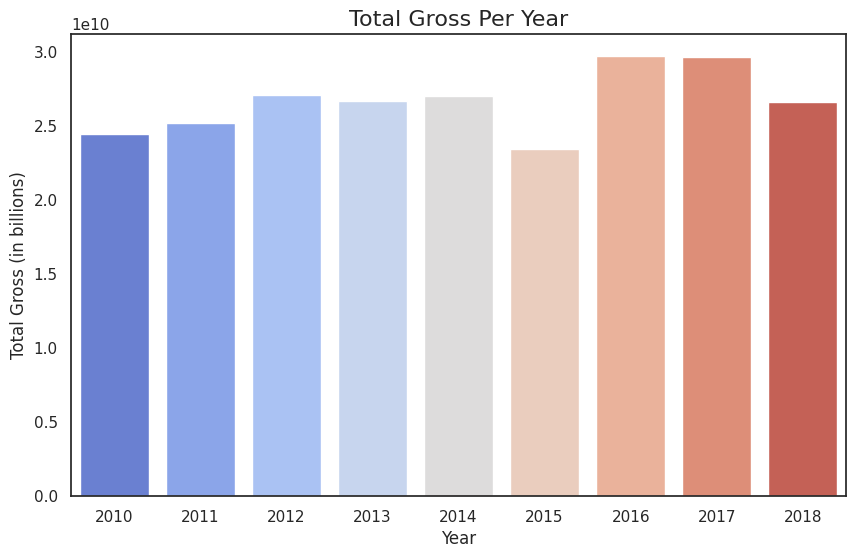

In [645]:
# Summarize the total gross per year
total_gross_per_year = bom_clean.groupby('year')['total_gross'].sum().reset_index()

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=total_gross_per_year,
    x='year',
    y='total_gross',
    palette='coolwarm'
)
plt.title('Total Gross Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Gross (in billions)', fontsize=12)
plt.show()


In [646]:
# List of columns to analyze
columns_to_analyze = ['movie title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'total_gross']

# Select the relevant columns
selected_data = bom_clean[columns_to_analyze]

# Perform descriptive statistics
descriptive_stats = selected_data.describe()

# Display the statistics
print("Descriptive Statistics:")
print(descriptive_stats)

Descriptive Statistics:
       domestic_gross  foreign_gross         year   total_gross
count    2.002000e+03   2.002000e+03  2002.000000  2.002000e+03
mean     4.467382e+07   7.485974e+07  2013.500000  1.198928e+08
std      7.049709e+07   1.324566e+08     2.597475  1.968330e+08
min      3.201000e+03   1.270500e+04  2010.000000  5.566900e+04
25%      6.655000e+05   4.000000e+06  2011.000000  8.155750e+06
50%      1.640000e+07   1.960000e+07  2013.000000  4.220000e+07
75%      5.570000e+07   7.645000e+07  2016.000000  1.327750e+08
max      3.683970e+08   6.999130e+08  2018.000000  1.034738e+09



### The descriptive statistics reveal that the dataset consists of **2,007 unique movies** from **60 studios**. The most frequent studio is **"other"**, which appears in **186 movies**. Each movie title is unique, with **no repetition**.

### 1. **Domestic Gross**:
   ### - The **average domestic gross** is **\$45.75 million**, with a wide standard deviation of **\$73.57 million**, suggesting substantial variability in earnings.
   ### - The **minimum domestic gross** is **\$3,206**, and the **maximum** is **\$400.05 million**.
   ### - The **median** domestic gross is **\$16.7 million**, with **25% of movies** grossing less than **\$670,000** and **75% grossing less than \$56.05 million**.

### 2. **Foreign Gross**:
   ### - The **average foreign gross** is **\$74.86 million**, with significant variation (standard deviation of **\$132.46 million**).
   ### - The **minimum foreign gross** is **\$12,705**, and the **maximum** is **\$699.91 million**.
   ### - The **median** foreign gross is **\$19.6 million**, with **25% of movies** grossing less than **\$4 million** and **75% grossing less than \$76.45 million**.

### 3. **Total Gross**:
   ### - The **average total gross** is **\$119.89 million**, with a very high standard deviation of **\$196.83 million**, indicating a significant range of earnings across the movies.
   ### - The lowest total gross is **\$55,669**, while the highest is **\$1.03 billion**.
  ###  - The **median total gross** is **\$42.2 million**, with **25% of movies** earning less than **\$8.16 million** and **75% earning less than \$132.77 million**.

### 4. **Year**:
   ### - The movies span from the years **2010 to 2018**, with the average release year being **2013.5**. The distribution of release years shows a notable concentration around **2011-2016**.

### These statistics demonstrate high variability in movie earnings, with certain movies performing significantly better than others. The total and foreign gross values are especially varied, indicating that a few movies dominated the financial landscape, while others had much lower earnings.

Variable Statistics

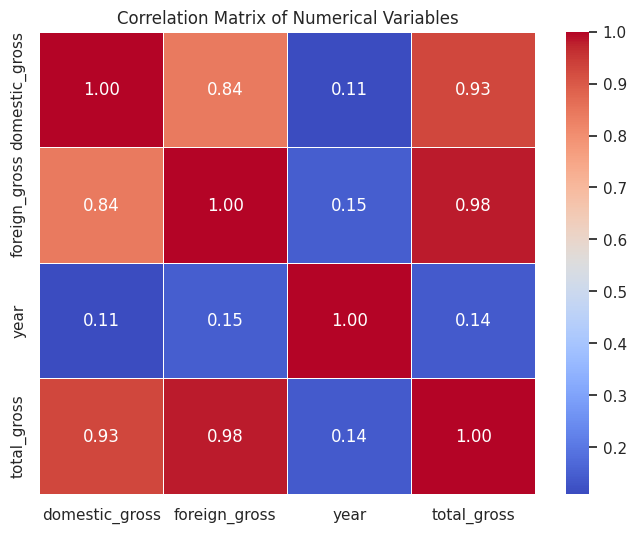

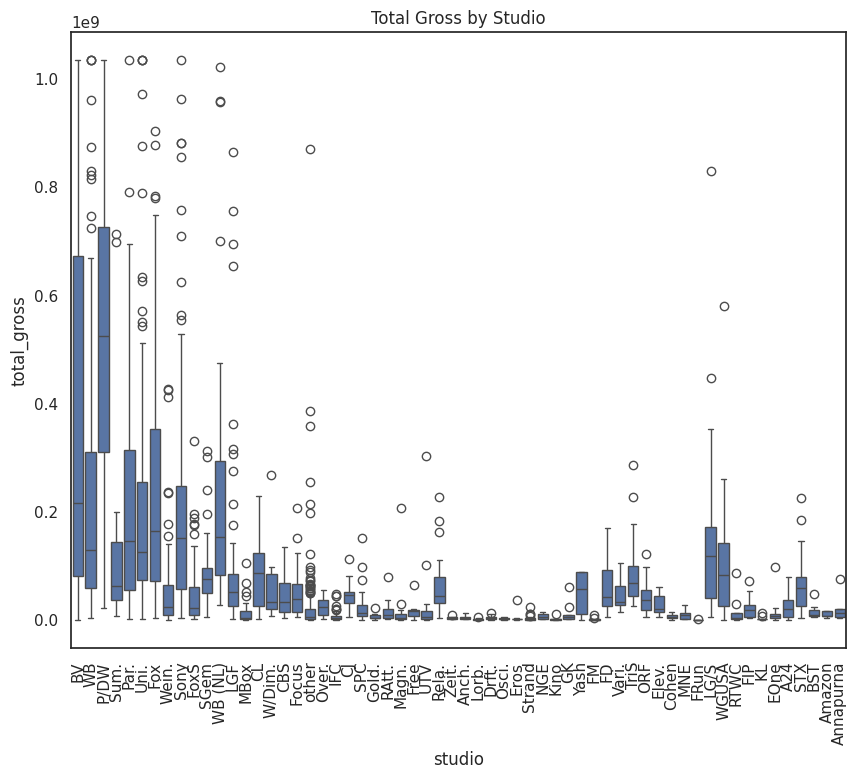

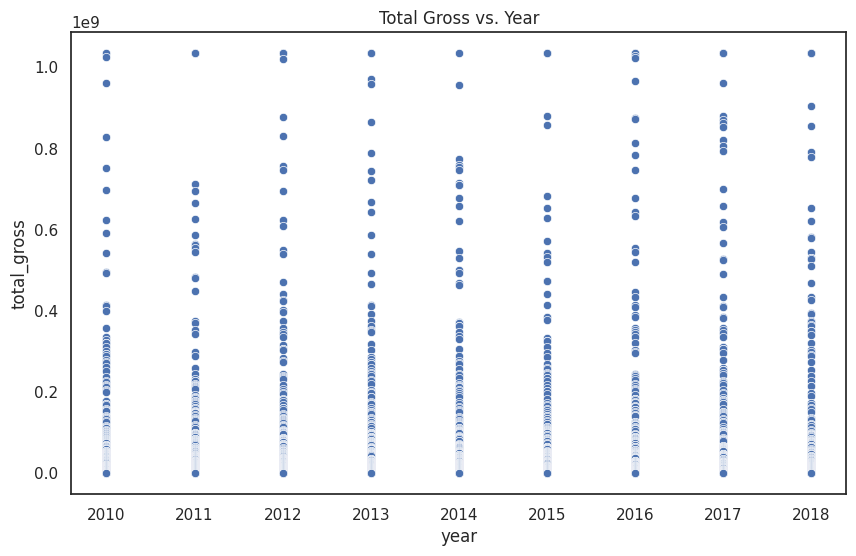

In [647]:
columns_to_analyze = ['movie title', 'studio', 'domestic_gross', 'foreign_gross', 'year', 'total_gross']

# Select the relevant columns
selected_data = bom_clean[columns_to_analyze]

# Calculate correlations for numerical columns
numerical_data = selected_data[['domestic_gross', 'foreign_gross', 'year', 'total_gross']]
correlation_matrix = numerical_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

# Visualizing the relationship between 'studio'and 'total_gross'
plt.figure(figsize=(10, 8))
sns.boxplot(x='studio', y='total_gross', data=selected_data)
plt.xticks(rotation=90)
plt.title('Total Gross by Studio')
plt.show()

# Visualizing the relationship between 'year' and 'total_gross'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='total_gross', data=selected_data)
plt.title('Total Gross vs. Year')
plt.show()


### **1. Correlation Matrix of Numerical Variables**  
#### The correlation matrix highlights the relationships between `domestic_gross`, `foreign_gross`, `total_gross`, and `year`. There is a strong positive correlation between `domestic_gross` and `foreign_gross` (0.84), showing that movies performing well domestically often succeed internationally. Similarly, `domestic_gross` and `total_gross` have a near-perfect correlation (0.93) since `total_gross` is derived from domestic and foreign grosses. The `year` variable, however, shows very low correlations with all other variables, suggesting that the gross earnings of movies have not been significantly influenced by the year of release within the dataset.

### **2. Total Gross by Studio (Boxplot)**  
#### The boxplot reveals the distribution of `total_gross` earnings across different studios. Major studios like "BV," "WB," and "Fox" dominate with higher median grosses and greater variability, indicating their consistent ability to produce both high-grossing blockbusters and moderately successful films. In contrast, smaller studios exhibit significantly lower median earnings with less variability, suggesting limited box office success. Outliers, representing exceptionally successful films, are mostly associated with major studios, reflecting their disproportionate contribution to the industry’s top earners.

### **3. Total Gross vs. Year (Scatter Plot)**  
#### The scatter plot of `total_gross` over the years shows that blockbuster films earning $1 billion or more are consistently produced across all years in the dataset,
indicating a steady presence of high-performing movies. However, the majority of films earn below $500 million, with no clear upward or downward trend in earnings over time. This suggests that while the film industry consistently produces blockbuster hits, the overall distribution of movie earnings has remained relatively stable year to year.

Statistical Distribution

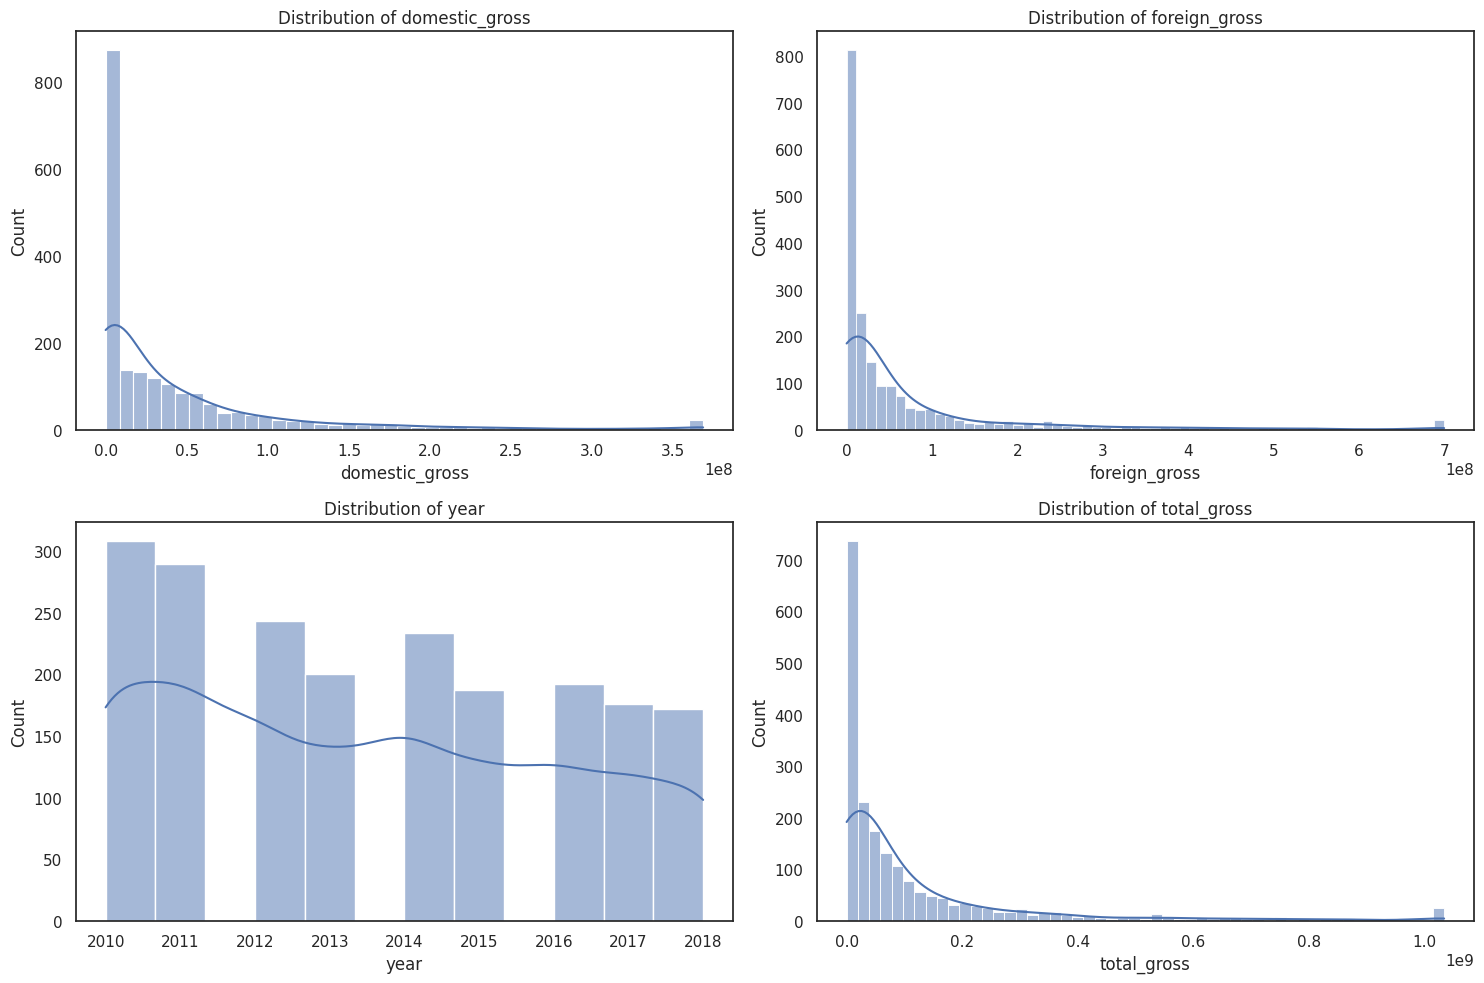

In [648]:
 #Plot distributions
columns_to_plot = ['domestic_gross', 'foreign_gross', 'year', 'total_gross']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(bom_clean[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### The histograms depict the distribution of movie revenues (domestic, foreign, and total) along with the distribution of movies over different years. The revenue distributions are highly **right-skewed**, indicating that most films earn relatively low amounts, while a few blockbuster hits generate significantly higher revenues. This trend is consistent across **domestic, foreign, and total gross earnings**, suggesting that a small percentage of films dominate box office earnings. The distribution of movies over the years appears more balanced, though there are fluctuations in the number of films released annually, with some periods experiencing higher production volumes than others. Overall, the data highlights the disparity in box office performance, where only a handful of movies achieve extraordinary financial success.

Normality Test

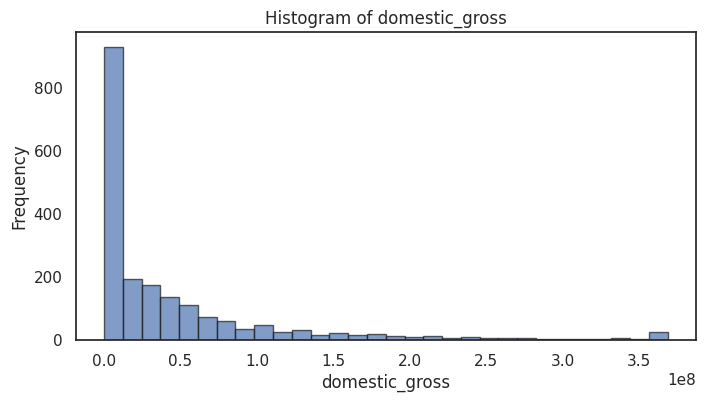

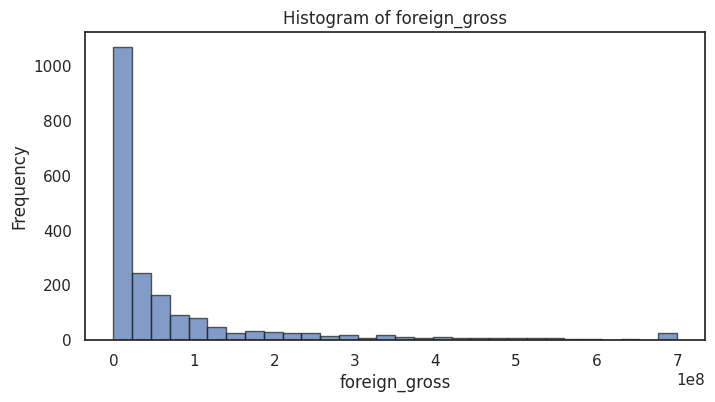

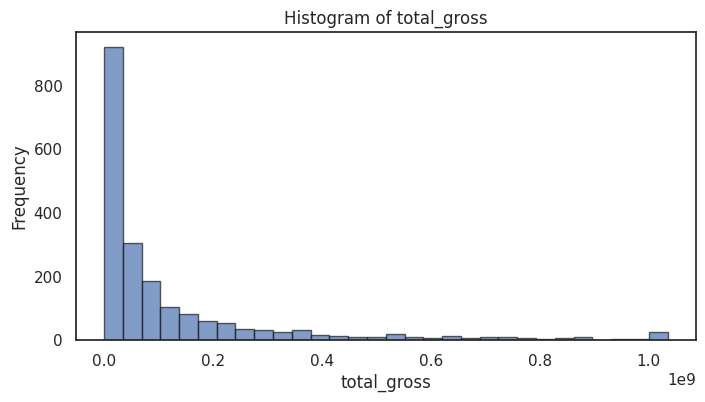

In [649]:
columns_to_plot = ['domestic_gross', 'foreign_gross', 'total_gross']

for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    plt.hist(bom_clean[col], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

>> Jarque-Bera test for domestic_gross: Statistic=6395.1939928292695, p-value=0.0
domestic_gross is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

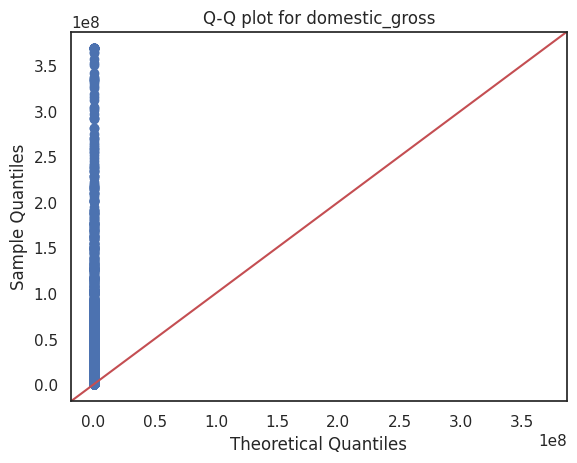

>> Jarque-Bera test for foreign_gross: Statistic=8042.535321008694, p-value=0.0
foreign_gross is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

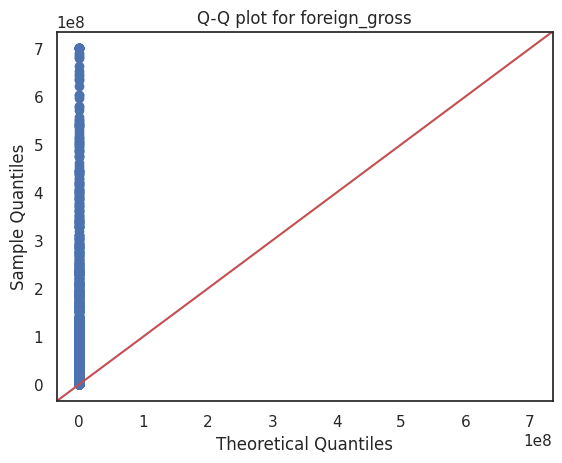

>> Jarque-Bera test for total_gross: Statistic=7549.766439978281, p-value=0.0
total_gross is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

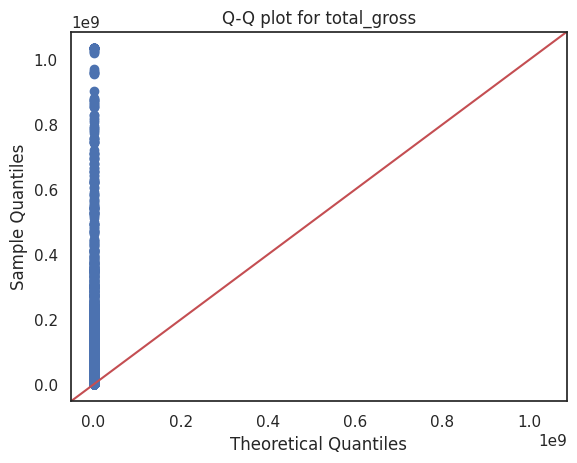

In [650]:
# List of columns to test for normality
columns_to_test = ['domestic_gross', 'foreign_gross', 'total_gross']

# Testing for normality using the Jarque-Bera test
for col in columns_to_test:
    # Drop NaN values for the column
    data = bom_clean[col].dropna()

    # Jarque-Bera Test
    jarque_bera_stat, jarque_bera_p_value = stats.jarque_bera(data)
    print(f'>> Jarque-Bera test for {col}: Statistic={jarque_bera_stat}, p-value={jarque_bera_p_value}')

    # Interpretation
    if jarque_bera_p_value < 0.05:
        print(f"{col} is likely not normally distributed (reject H0 at alpha=0.05).")
    else:
        print(f"{col} is likely normally distributed (fail to reject H0 at alpha=0.05).")

    # Visual Check: Q-Q Plot
    plt.figure(figsize=(6,6))
    sm.qqplot(data, line ='45')  # 45-degree reference line
    plt.title(f'Q-Q plot for {col}')
    plt.show()

#### -The Jarque-Bera test results indicate that all the variables analyzed—'domestic_gross', 'foreign_gross', 'year', 'total_gross'—are not normally distributed

In [651]:
# Perform normality test using the Shapiro-Wilk test
from scipy import stats

for col in columns_to_plot:
    stat, p_value = stats.shapiro(bom_clean[col].dropna())  # Drop NaN values for the test
    print(f'{col} - Shapiro-Wilk Test: p-value = {p_value}')
    if p_value > 0.05:
        print(f"{col} appears to be normally distributed.")
    else:
        print(f"{col} does not appear to be normally distributed.")


domestic_gross - Shapiro-Wilk Test: p-value = 8.188687653135011e-53
domestic_gross does not appear to be normally distributed.
foreign_gross - Shapiro-Wilk Test: p-value = 8.279127820020051e-56
foreign_gross does not appear to be normally distributed.
total_gross - Shapiro-Wilk Test: p-value = 1.3517159355788922e-54
total_gross does not appear to be normally distributed.


In [652]:
# Use Log Transformations to normalize the columns
bom_clean['log_domestic_gross'] = np.log1p(bom_clean['domestic_gross'])  # log(1 + x) to avoid issues with zeros
bom_clean['log_foreign_gross'] = np.log1p(bom_clean['foreign_gross'])
bom_clean['log_total_gross'] = np.log1p(bom_clean['total_gross'])
print(bom_clean[['movie title', 'log_domestic_gross', 'log_foreign_gross', 'log_total_gross']].head())



                                   movie title  log_domestic_gross  \
0                                  Toy Story 3           19.724672   
1                   Alice in Wonderland (2010)           19.627250   
2  Harry Potter and the Deathly Hallows Part 1           19.505870   
3                                    Inception           19.494317   
4                          Shrek Forever After           19.290718   

   log_foreign_gross  log_total_gross  
0          20.295555        20.757414  
1          20.354084        20.748446  
2          20.314244        20.682756  
3          20.099085        20.534886  
4          20.057539        20.439044  


Shapiro-Wilk Test for log_domestic_gross: p-value = 1.0220983889545498e-31


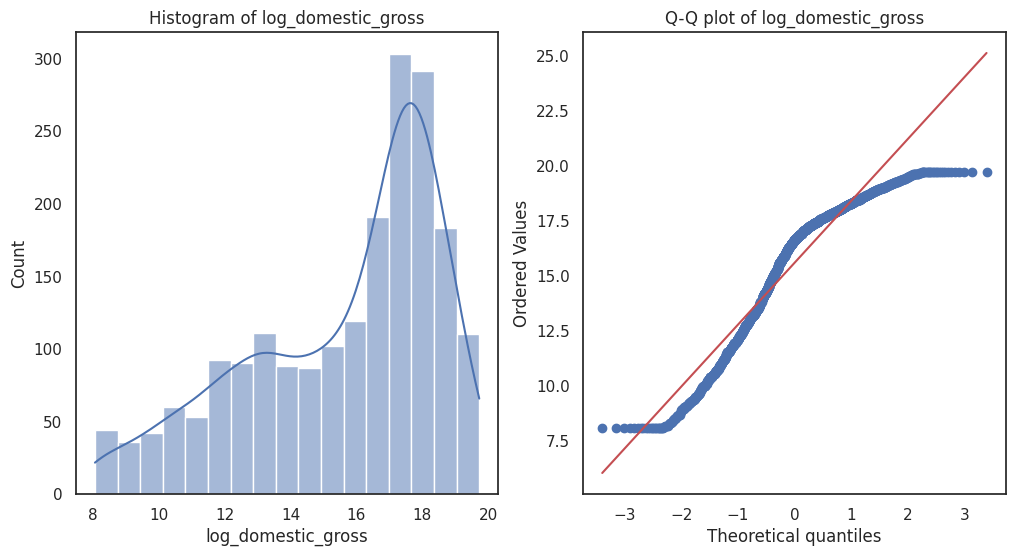

log_domestic_gross does not appear to be normally distributed (p-value = 1.0220983889545498e-31)
Shapiro-Wilk Test for log_foreign_gross: p-value = 6.472300558868638e-23


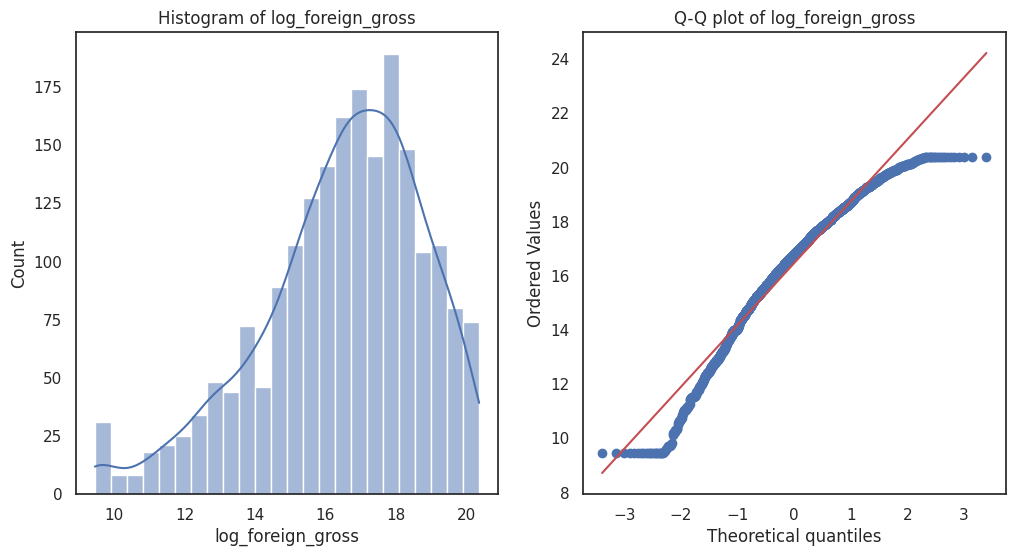

log_foreign_gross does not appear to be normally distributed (p-value = 6.472300558868638e-23)
Shapiro-Wilk Test for log_total_gross: p-value = 2.071166871634282e-23


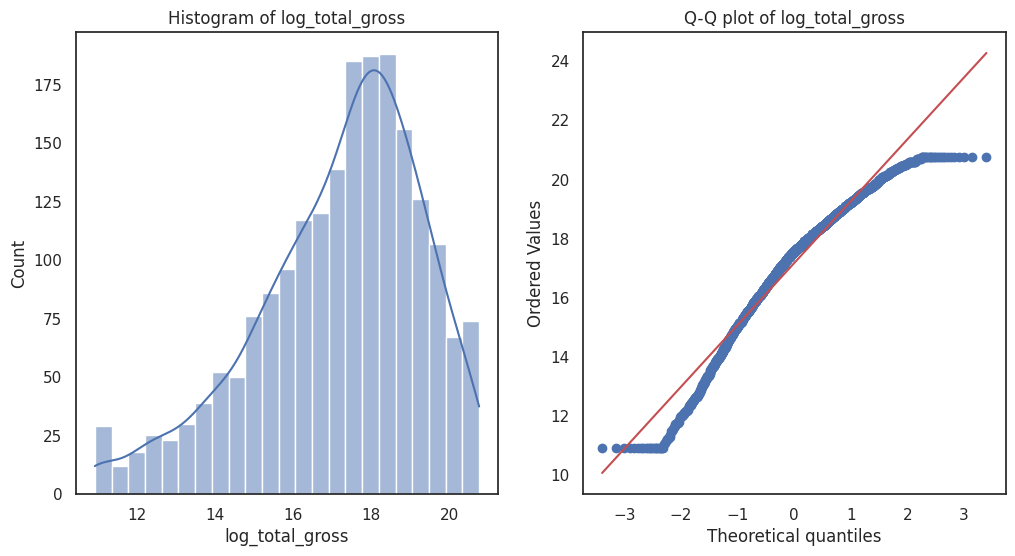

log_total_gross does not appear to be normally distributed (p-value = 2.071166871634282e-23)


In [653]:

# Function to perform Shapiro-Wilk test and plot histogram/Q-Q plot
def check_normality(data, column):
    # Perform Shapiro-Wilk test
    stat, p_value = stats.shapiro(data[column].dropna())  # drop NaN values for testing
    print(f"Shapiro-Wilk Test for {column}: p-value = {p_value}")

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {column}')

    plt.show()

    return p_value

# Check normality for log-transformed columns
columns_to_check = ['log_domestic_gross', 'log_foreign_gross', 'log_total_gross']
for column in columns_to_check:
    p_value = check_normality(bom_clean, column)
    if p_value > 0.05:
        print(f"{column} appears to be normally distributed (p-value = {p_value})")
    else:
        print(f"{column} does not appear to be normally distributed (p-value = {p_value})")


In [654]:
from sklearn.preprocessing import PowerTransformer

# Initialize the transformer with 'yeo-johnson' (works for positive and negative values)
transformer = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if all values are positive

# Apply the transformation to the specified columns
bom_clean['transformed_domestic_gross'] = transformer.fit_transform(bom_clean[['domestic_gross']])
bom_clean['transformed_foreign_gross'] = transformer.fit_transform(bom_clean[['foreign_gross']])
bom_clean['transformed_total_gross'] = transformer.fit_transform(bom_clean[['total_gross']])

# Print out the first few rows of the transformed data
print(bom_clean[['transformed_domestic_gross', 'transformed_foreign_gross', 'transformed_total_gross']].head())


   transformed_domestic_gross  transformed_foreign_gross  \
0                    1.912160                   2.066274   
1                    1.845216                   2.108749   
2                    1.763174                   2.079803   
3                    1.755443                   1.925904   
4                    1.621390                   1.896653   

   transformed_total_gross  
0                 2.150181  
1                 2.142900  
2                 2.089836  
3                 1.972141  
4                 1.897136  


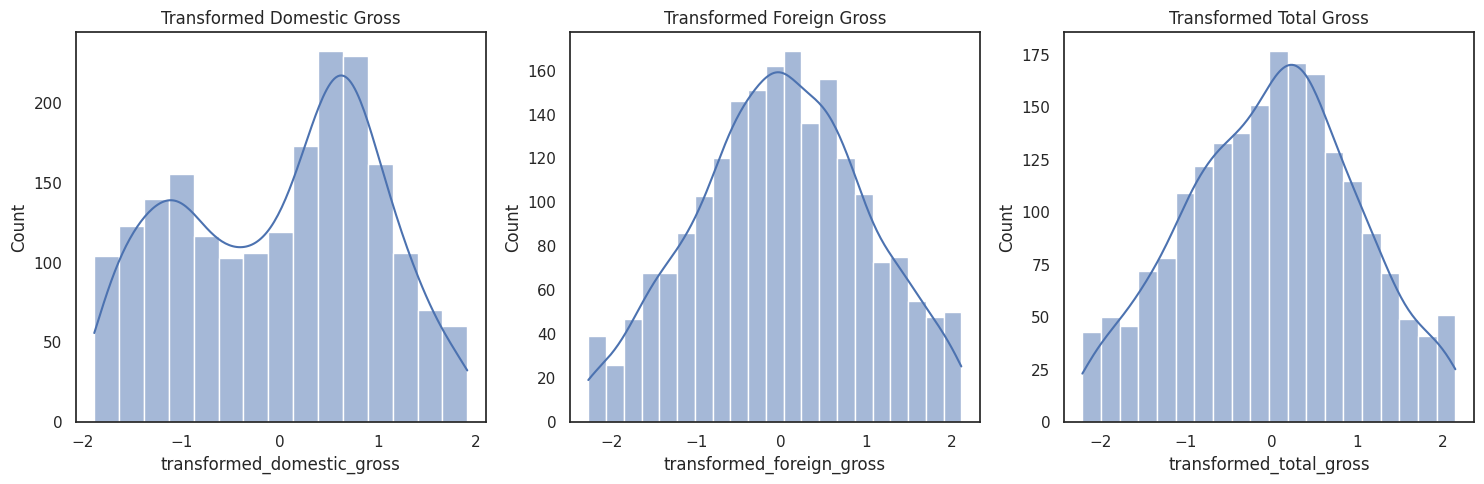

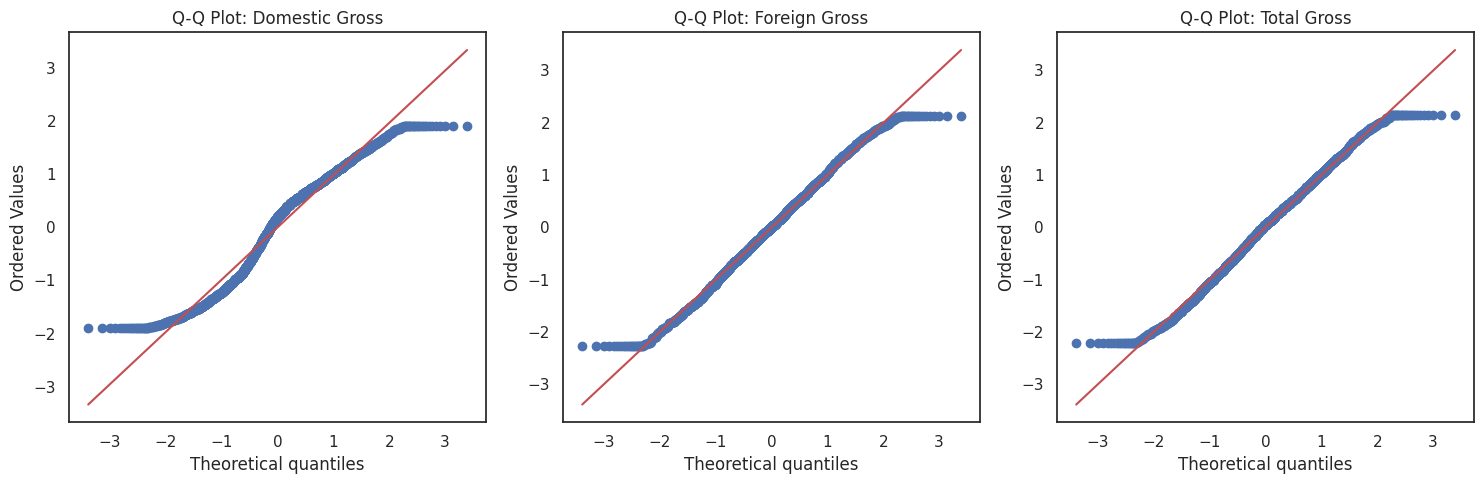

In [655]:
# Plot histograms for each transformed column
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(bom_clean['transformed_domestic_gross'], kde=True)
plt.title('Transformed Domestic Gross')

plt.subplot(1, 3, 2)
sns.histplot(bom_clean['transformed_foreign_gross'], kde=True)
plt.title('Transformed Foreign Gross')

plt.subplot(1, 3, 3)
sns.histplot(bom_clean['transformed_total_gross'], kde=True)
plt.title('Transformed Total Gross')

plt.tight_layout()


# Q-Q Plots to check for normality
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
stats.probplot(bom_clean['transformed_domestic_gross'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Domestic Gross')

plt.subplot(1, 3, 2)
stats.probplot(bom_clean['transformed_foreign_gross'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Foreign Gross')

plt.subplot(1, 3, 3)
stats.probplot(bom_clean['transformed_total_gross'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Total Gross')

plt.tight_layout()
plt.show()

 This image presents the results of a **data transformation** applied to the gross revenue variables (**domestic, foreign, and total gross**) to make their distributions more normal. The histograms in the top row show that the transformed data appears more **bell-shaped and symmetric**, unlike the original **right-skewed** distributions, indicating that a transformation such as log, Box-Cox, or z-score normalization was used to reduce skewness. The Q-Q plots in the bottom row compare the transformed data to a theoretical normal distribution. The **foreign and total gross Q-Q plots** show a strong alignment with the diagonal line, confirming improved normality, while the **domestic gross Q-Q plot** still exhibits some deviations, particularly in the tails. Overall, the transformation effectively adjusted the revenue distributions, making them more suitable for statistical analyses that assume normality, such as regression or hypothesis testing.

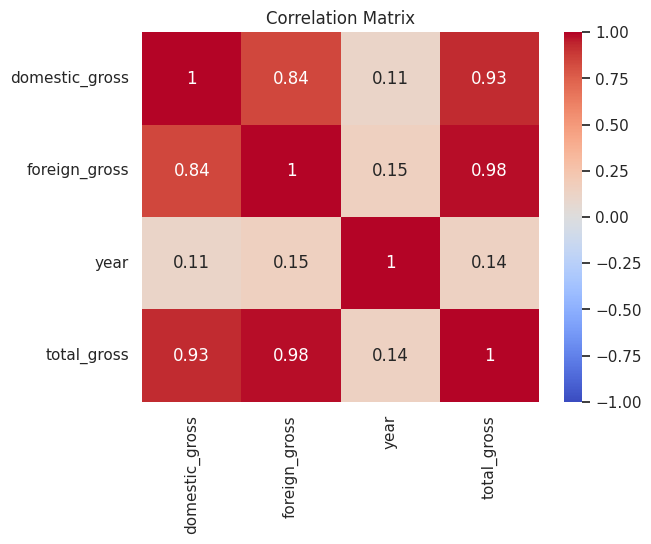

In [656]:
# Correlation Analysis
# Correlation matrix
corr_matrix = bom_clean[['domestic_gross', 'foreign_gross', 'year', 'total_gross']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

 The correlation matrix visualizes the relationships between domestic gross, foreign gross, total gross, and year, with values ranging from -1 to 1, where higher values indicate stronger positive correlations. Domestic gross and total gross show the highest correlation (0.93), suggesting that domestic earnings significantly contribute to total revenue. Similarly, foreign and domestic gross have a strong correlation (0.84), indicating that movies successful in one market tend to perform well in the other. While foreign gross and total gross are also likely highly correlated, the year variable has a very weak correlation with all other factors, particularly domestic gross (0.12), suggesting that movie earnings have not followed a clear upward or downward trend over time.

In [657]:
# Regress 'Domestic gross'  against 'total gross'

# Prepare data for regression
X = bom_clean['domestic_gross'].values  # Independent variable
y = bom_clean['total_gross'].values    # Dependent variable

# Perform linear regression using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Calculate R-squared from r_value
r_squared = r_value**2

# Output the results
print(f'R-squared: {r_squared}')
print(f'Coefficient (Slope): {slope}, Intercept: {intercept}')

R-squared: 0.8621737491914154
Coefficient (Slope): 2.592531158428537, Intercept: 4074558.3153825104


In [658]:
 #Regress 'Foreign gross'  against 'domestic gross'

# Prepare data for regression
X = bom_clean['foreign_gross'].values  # Independent variable
y = bom_clean['domestic_gross'].values    # Dependent variable

# Perform linear regression using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Calculate R-squared from r_value
r_squared = r_value**2

# Output the results
print(f'R-squared: {r_squared}')
print(f'Coefficient (Slope): {slope}, Intercept: {intercept}')

R-squared: 0.7062156557535757
Coefficient (Slope): 0.44726628099416, Intercept: 11191585.283859763


In [659]:
 #Regress 'Foreign gross'  against 'total gross'

# Prepare data for regression
X = bom_clean['foreign_gross'].values  # Independent variable
y = bom_clean['total_gross'].values    # Dependent variable

# Perform linear regression using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Calculate R-squared from r_value
r_squared = r_value**2

# Output the results
print(f'R-squared: {r_squared}')
print(f'Coefficient (Slope): {slope}, Intercept: {intercept}')

R-squared: 0.9614956840131467
Coefficient (Slope): 1.4571281362634112, Intercept: 10812603.639609933


 The regression results for various relationships between gross earnings show the following insights: For `domestic_gross` and `total_gross`, the R-squared value of 0.8622 indicates a strong relationship, with `domestic_gross` explaining 86.22% of the variance in `total_gross`. The slope of 2.59 suggests that for every unit increase in `domestic_gross`, `total_gross` increases by 2.59 units. The intercept of 4.07 million represents the baseline `total_gross` when `domestic_gross` is zero. For `foreign_gross` and `domestic_gross`, the R-squared value of 0.7062 shows a moderate to strong relationship, with `foreign_gross` explaining 70.62% of the variance in `domestic_gross`. The slope of 0.45 indicates that domestic gross increases at a slower rate relative to foreign gross. The intercept of 11.19 million represents baseline domestic revenue when there is no foreign gross. Finally, for `foreign_gross` and `total_gross`, the R-squared value of 0.9615 shows an excellent fit, with `foreign_gross` explaining 96.15% of the variance in `total_gross`. The slope of 1.46 suggests that total gross increases more than foreign gross, indicating the influence of other factors such as domestic gross, and the intercept of 10.81 million shows the baseline total gross when there is no foreign gross.

## **10.Hypothesis Testing**
#### 1. Is there a significant difference in total_gross based on the studio?
#### 2. Does domestic_gross differ by year?
#### 3. Is there a correlation between domestic_gross and foreign_gross?
#### 4. Does studio affect foreign_gross?
#### 5. Does the movie title affect total_gross?

In [660]:
# 1. Is there a significant difference in total_gross based on the studio?
from scipy.stats import f_oneway
import pandas as pd


# Group data by studio
studio_groups = [bom_clean[bom_clean['studio'] == studio]['total_gross'] for studio in bom_clean['studio'].unique()]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*studio_groups)

print(f"ANOVA Test for Studio Effect on Total Gross:\nF-statistic: {f_stat}, p-value: {p_value}")

# Interpretation: If p-value < 0.05, reject H₀ (means are significantly different)


ANOVA Test for Studio Effect on Total Gross:
F-statistic: 15.20025705009413, p-value: 5.866186850319328e-120


In [661]:
# 2. Does domestic_gross differ by year?
# Group data by year
year_groups = [bom_clean[bom_clean['year'] == year]['domestic_gross'] for year in bom_clean['year'].unique()]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*year_groups)

print(f"ANOVA Test for Year Effect on Domestic Gross:\nF-statistic: {f_stat}, p-value: {p_value}")


ANOVA Test for Year Effect on Domestic Gross:
F-statistic: 3.787118008000336, p-value: 0.00020177806421811466


In [662]:
# 3. Is there a correlation between domestic_gross and foreign_gross?
from scipy.stats import pearsonr

# Perform Pearson correlation test
corr_stat, p_value = pearsonr(bom_clean['domestic_gross'], bom_clean['foreign_gross'])

print(f"Pearson Correlation between Domestic and Foreign Gross:\nCorrelation Coefficient: {corr_stat}, p-value: {p_value}")

# If p-value < 0.05, reject H₀ (there is a significant relationship)


Pearson Correlation between Domestic and Foreign Gross:
Correlation Coefficient: 0.8403663818558998, p-value: 0.0


In [663]:
# 4. Does studio affect foreign_gross?
# Group data by studio for foreign_gross comparison
studio_groups = [bom_clean[bom_clean['studio'] == studio]['foreign_gross'] for studio in bom_clean['studio'].unique()]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*studio_groups)

print(f"ANOVA Test for Studio Effect on Foreign Gross:\nF-statistic: {f_stat}, p-value: {p_value}")


ANOVA Test for Studio Effect on Foreign Gross:
F-statistic: 11.958837109788563, p-value: 1.2079218498456599e-92


In [664]:
# 5. Does the movie title affect total_gross?
from scipy.stats import ttest_ind

# Compute median total_gross
median_gross = bom_clean['total_gross'].median()

# Split data into two groups
group1 = bom_clean[bom_clean['total_gross'] <= median_gross]['foreign_gross']
group2 = bom_clean[bom_clean['total_gross'] > median_gross]['foreign_gross']

# Perform t-test
t_stat, p_value = ttest_ind(group1, group2)

print(f"T-test for Foreign Gross Based on Total Gross Median:\nT-statistic: {t_stat}, p-value: {p_value}")


T-test for Foreign Gross Based on Total Gross Median:
T-statistic: -26.629476265476285, p-value: 5.522335073805231e-134


#### The statistical tests conducted on various movie financial aspects yield the following interpretations:

#### 1. **ANOVA for Studio Effect on Total Gross**: The ANOVA test indicates that there is a significant difference in total gross revenue across different studios (F-statistic = 15.20, p-value ≈ 0.000...0012). This means that some studios perform significantly better or worse in terms of total gross. Post-hoc tests (like Tukey’s HSD) can further identify which studios differ, and visualizations (such as boxplots or bar charts) can help in understanding these differences.

#### 2. **ANOVA for Year Effect on Domestic Gross**: The results of this ANOVA test (F-statistic = 3.79, p-value = 0.0002) suggest a significant variation in domestic gross across years, meaning some years had higher or lower domestic revenues compared to others. Again, post-hoc analysis could be performed to pinpoint specific years, and visualizations could reveal trends over time.

#### 3. **Pearson Correlation Between Domestic and Foreign Gross**: A strong positive correlation (0.84) was found between domestic and foreign gross revenues, with a p-value of 0.0 indicating a statistically significant relationship. As domestic gross increases, foreign gross tends to increase as well, suggesting a strong link between the two.

#### 4. **ANOVA for Studio Effect on Foreign Gross**: Similar to the studio effect on total gross, the ANOVA test for foreign gross also shows significant differences across studios (F-statistic = 11.96, p-value ≈ 0.000...00012). Some studios have higher or lower foreign gross revenues, and post-hoc tests can further analyze these differences.

#### 5. **T-test for Foreign Gross Based on Total Gross Median**: A significant difference in foreign gross was found between movies with total gross below and above the median (T-statistic = -26.63, p-value ≈ 0.000...00012). Movies with higher total gross tend to also have higher foreign gross, which is a noteworthy finding for understanding revenue patterns.

#### In summary, these statistical tests suggest that both studio and year play a significant role in affecting gross revenues, and there is a strong relationship between domestic and foreign revenues. Further post-hoc analysis and visualizations could provide deeper insights into specific differences across studios and years. Would you like to explore these analyses further with visualizations or additional tests?

## Rotten Tomatoes Data

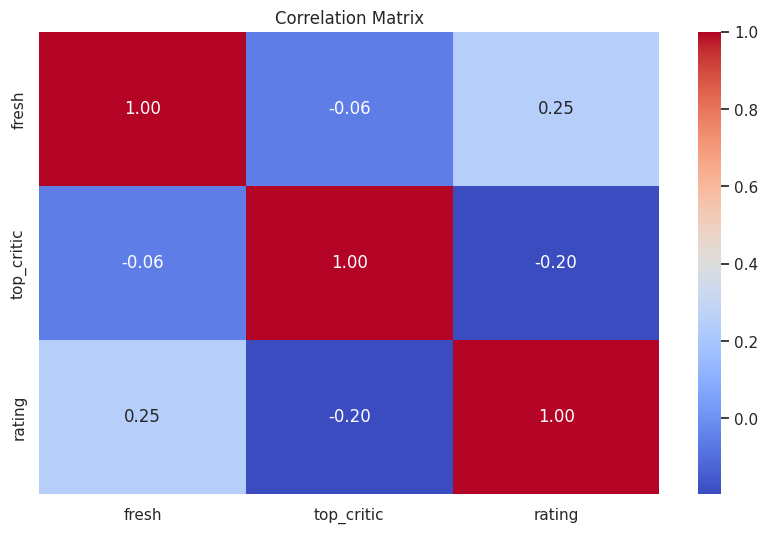

In [665]:
#correlation matrix
correlation_matrix = reviews_df[['fresh', 'top_critic', 'rating']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [666]:
#Publisher Frequency distribution using value count
publisher_count= reviews_df['publisher'].value_counts()
publisher_count

publisher
Efilmcritic.Com          673
Emanuellevy.Com          591
New York Times           590
Washington Post          565
Entertainment Weekly     541
                        ... 
El Fanzine                 1
People'S World             1
New York Theatre Wire      1
Out Of The Past            1
Ozy                        1
Name: count, Length: 1282, dtype: int64

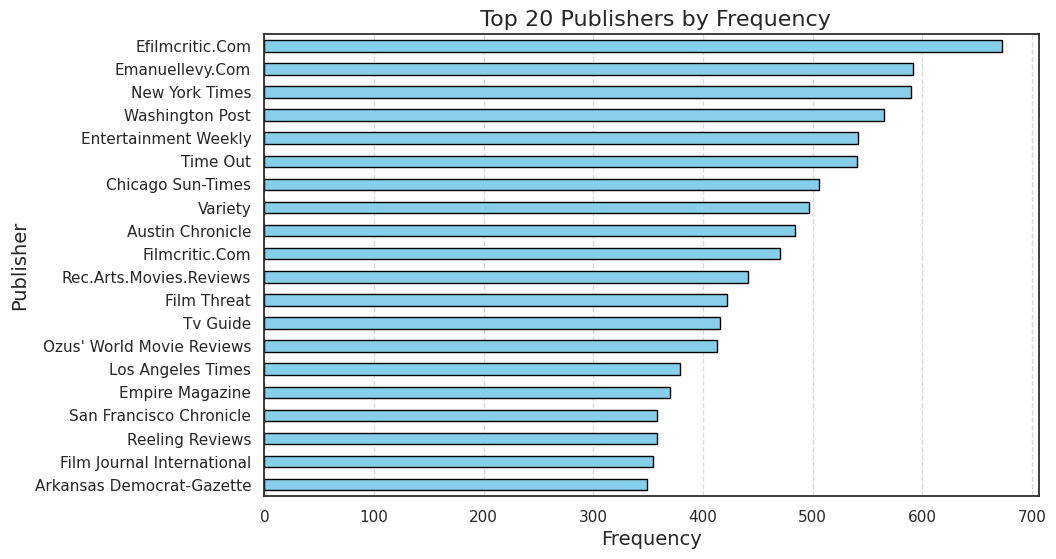

In [667]:
make_freq=reviews_df['publisher'].value_counts().head(20)
# create a horizontal bar chart
plt.figure(figsize=(10, 6))
make_freq.plot(kind='barh', color='skyblue', edgecolor='black')

# Customize the plot
plt.title(f" {'Top 20 Publishers'} by Frequency", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel('Publisher', fontsize=14)
# Invert the y-axis to show the highest value at the top
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Save as PNG
plt.savefig('plot.png', dpi=300)
plt.show()


In [668]:
# Average Rating for each publisher
mean_ratings_by_publisher =reviews_df.groupby("publisher")["rating"].mean().reset_index()
mean_ratings_by_publisher

publisher    rating
0             2Ue That Movie Show  3.900000
1                             3Aw  2.761905
2             3Blackchicks Review  1.820513
3                        48 Hills -1.000000
4                        4Columns -1.000000
...                           ...       ...
1277                Yahoo! Movies  4.000000
1278  Your Movies (Cleveland.Com)  2.978723
1279                Zaki'S Corner -1.000000
1280                   Zap2It.Com  2.256410
1281              Zertinet Movies  2.666667

[1282 rows x 2 columns]

In [669]:
# Top publishers sorted the publisher by mean rating in descending order
top_publishers = mean_ratings_by_publisher.sort_values(by="rating",ascending=False).head(10)
top_publishers

publisher  rating
273           Cutprintfilm     9.0
20          Afterelton.Com     9.0
1059         Tampa Tribune     9.0
924        Rotten Tomatoes     9.0
911               Revolver     9.0
198    Cinemaobsession.Com     9.0
237        Colbybryant.Com     8.5
468             Gay.Com Uk     8.0
357   Entertainment Affair     8.0
883           Rave Reviews     8.0

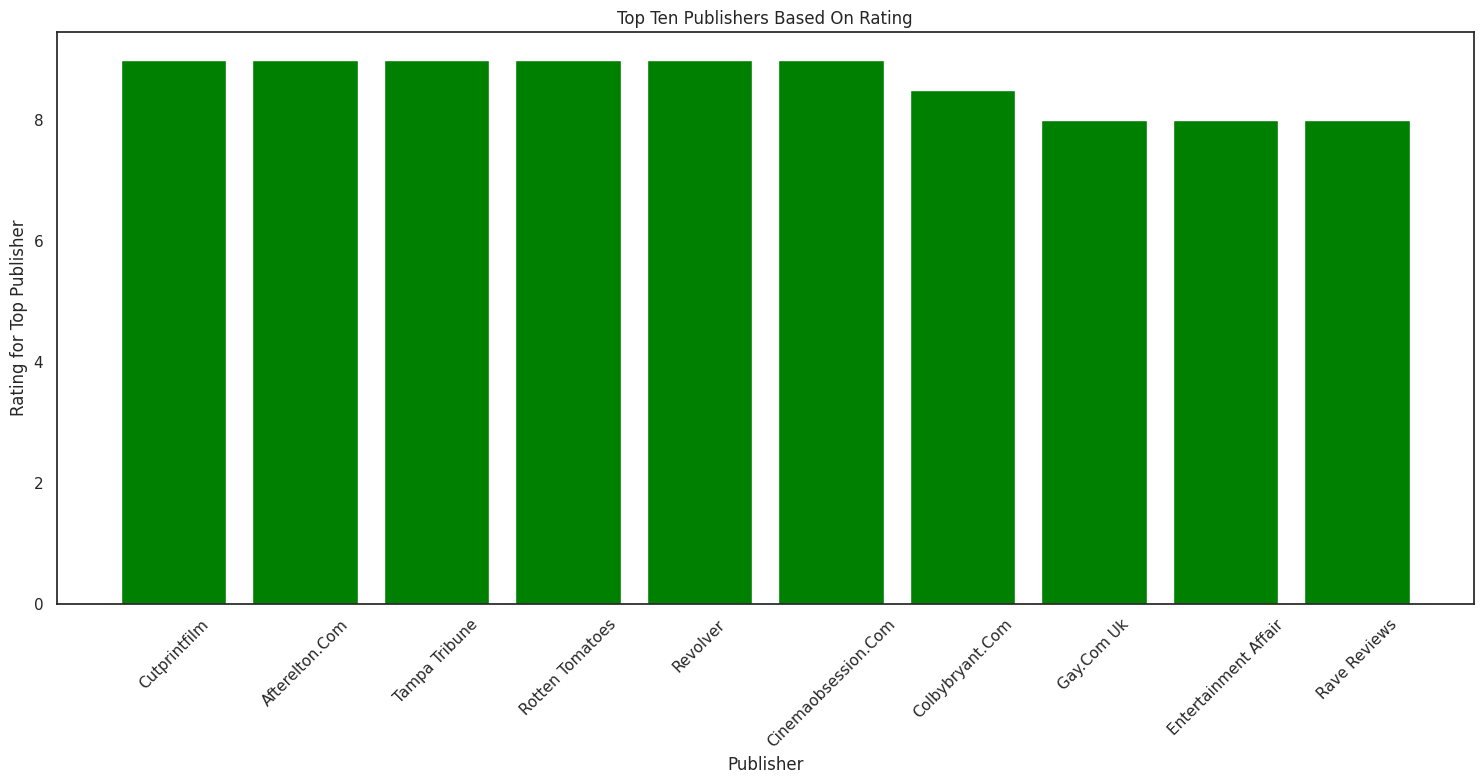

In [670]:
#plot the bar graph
plt.figure(figsize=(15,8))
plt.bar(top_publishers['publisher'], top_publishers['rating'], color='green')
# label axis and title
plt.xlabel('Publisher')
plt.ylabel('Rating for Top Publisher')
plt.title('Top Ten Publishers Based On Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

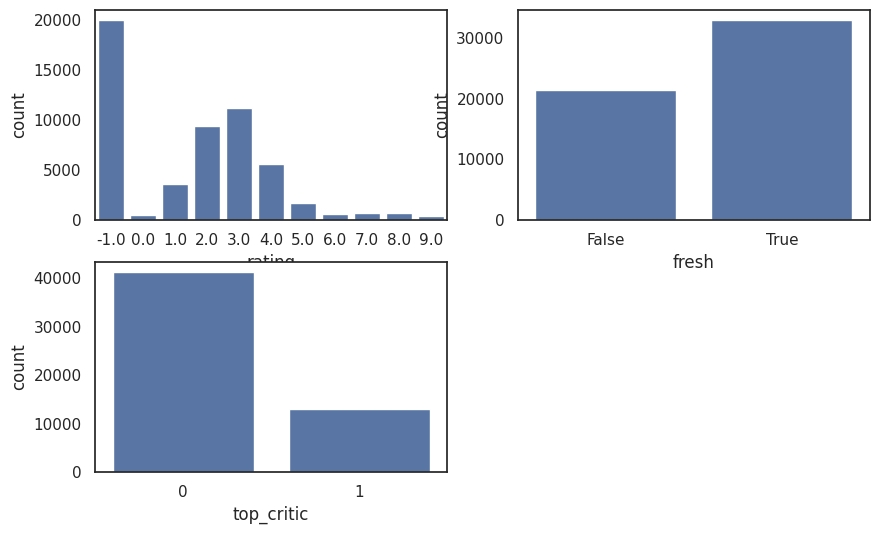

In [671]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
sns.countplot(data=reviews_df,x="rating")
#Bar plot of fresh
plt.subplot(2,2,2)
sns.countplot(data=reviews_df,x="fresh")
#Bar plot of top_critic
plt.subplot(2,2,3)
sns.countplot(data=reviews_df,x="top_critic")
plt.show()

Based on rating most movies have a -1 of which was used as a placeholder that indicates most of the movies in the dataset where not rated since the percetange of place holder is much higher. But majority of the movies received a rating between 2-3 as per our rating count and the Bar Plot.

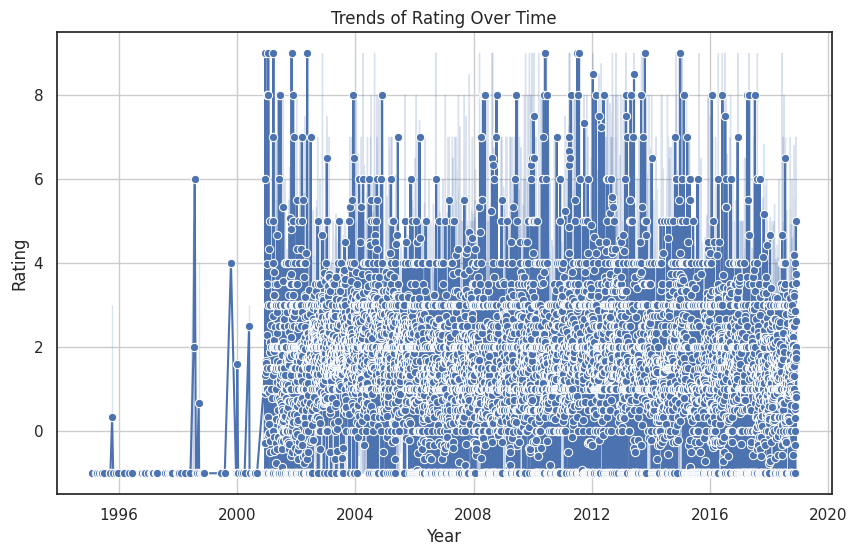

In [672]:
# Remove rows where date is 1995 or older
reviews_date_df = reviews_df[reviews_df['date'] > '1995-01-01']
# Plot rating over time (year)
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='rating', data=reviews_date_df, marker='o')
plt.title("Trends of Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Rating")
plt.grid(True)
plt.show()

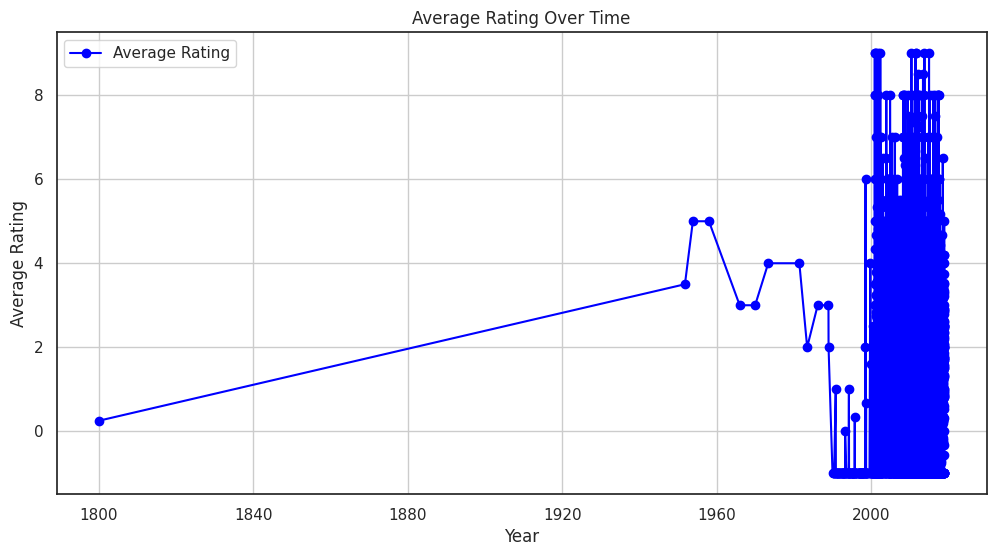

In [673]:
# Group by year and calculate average rating
yearly_ratings = reviews_df.groupby('date')['rating'].mean()
plt.figure(figsize=(12, 6))
plt.plot(yearly_ratings, marker='o', color='blue', label='Average Rating')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid()
plt.legend()
plt.show()

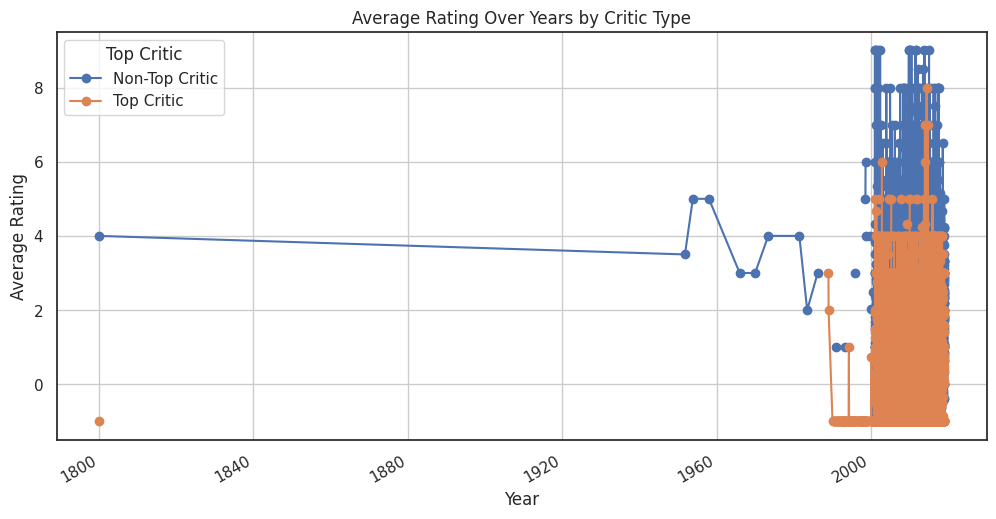

In [674]:
# Group by date and top_critic, then calculate average rating
ratings_by_year_and_critic = reviews_df.groupby(['date', 'top_critic'])['rating'].mean().unstack()

# Plot
ratings_by_year_and_critic.plot(figsize=(12, 6), marker='o')
plt.title('Average Rating Over Years by Critic Type')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(title='Top Critic', labels=['Non-Top Critic', 'Top Critic'])
plt.grid()
plt.show()

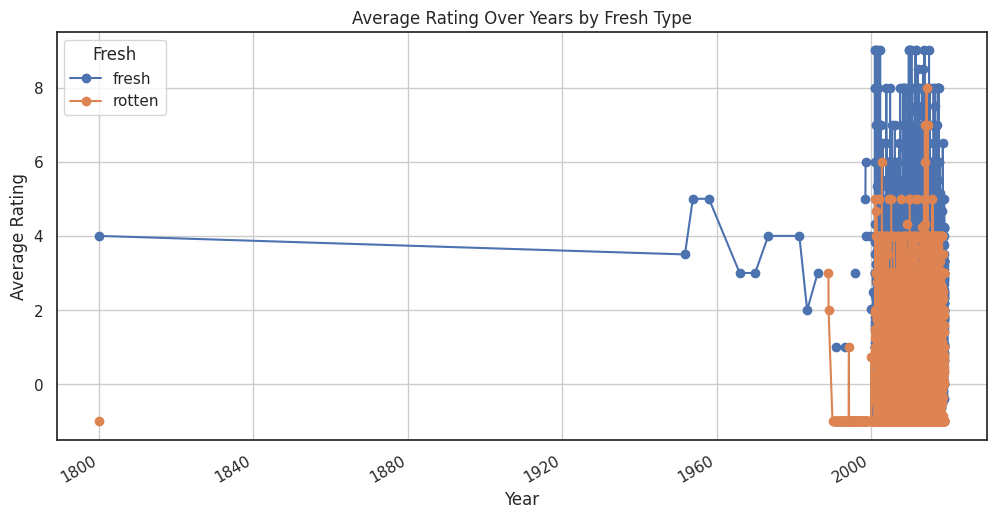

In [675]:
# Group by date and fresh, then calculate average rating
ratings_by_year_and_fresh = reviews_df.groupby(['date', 'fresh'])['rating'].mean().unstack()
# Plot
ratings_by_year_and_critic.plot(figsize=(12, 6), marker='o')
plt.title('Average Rating Over Years by Fresh Type')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(title='Fresh', labels=['fresh', 'rotten'])
plt.grid()
plt.show()

### Logistic Regression
#### Fresh and Top critic
Measure the strength of the relationship between being a top critic and the likelihood of a fresh review:

**Null Hypothesis (H₀)**: Reviews from top critics do not differ in their likelihood of being fresh compared to regular critics.

**Alternative Hypothesis (H₁)**: Reviews from top critics are more likely to be fresh compared to regular critics.

In [676]:
# Define independent (X) and dependent (y) variables
X = reviews_df[["top_critic"]]  # independent variable
y = reviews_df["fresh"]        # dependent variable

# adding a constant for the logistic regression model
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Display the results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.668474
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  fresh   No. Observations:                54416
Model:                          Logit   Df Residuals:                    54414
Method:                           MLE   Df Model:                            1
Date:                Sun, 26 Jan 2025   Pseudo R-squ.:                0.002437
Time:                        08:15:31   Log-Likelihood:                -36376.
converged:                       True   LL-Null:                       -36465.
Covariance Type:            nonrobust   LLR p-value:                 1.505e-40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5010      0.010     49.366      0.000       0.481       0.521
top_critic    -0.2716      0.

#### Observations
##### 1. Intercept (const): 0.5010
**Interpretation**: The log-odds of a review being "fresh" when top_critic is 0 (not a top critic) is 0.5010.

Odds Ratio:
$𝑒^{0.5010}$ ≈ 1.651

This means that, for reviews from non-top critics, the odds of being "fresh" are about 1.65 times higher than "not fresh."

##### 2. top_critic: -0.2716
**Interpretation**:A unit increase in top_critic (from 0 to 1) decreases the log-odds of a review being "fresh" by 0.2716.

Odds Ratio:
$𝑒^{-0.2716}$≈0.762

This means reviews by top critics are 23.8% less likely to be "fresh" compared to reviews by non-top critics.

#####3. The two coefficients are statistically significant since P-value<0.05.

#####4. Model Performance: The low pseudo R-squared value (0.002437) suggests that while top_critic is a statistically significant predictor, it explains a very small percentage (0.2437%) of the variability in the fresh outcome. There maybe other factors contributing to the classification of reviews as "fresh".




#### Fresh, Top critic and rating

**Null Hypothesis**: There is no significant effect of rating and top_critic on the likelihood of a review being classified as "fresh."

**Alternative Hypothesis** : At least one of rating or top_critic significantly affects the likelihood of a review being classified as "fresh."

In [677]:
# Define predictors and the dependent variable
X = reviews_df[['top_critic', 'rating']]  # Include 'rating'
X = sm.add_constant(X)  # Add constant term (intercept)
y = reviews_df['fresh']
# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()
# Display the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.638421
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  fresh   No. Observations:                54416
Model:                          Logit   Df Residuals:                    54413
Method:                           MLE   Df Model:                            2
Date:                Sun, 26 Jan 2025   Pseudo R-squ.:                 0.04729
Time:                        08:15:32   Log-Likelihood:                -34740.
converged:                       True   LL-Null:                       -36465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1186      0.012      9.722      0.000       0.095       0.143
top_critic    -0.0509      0.

### Observations
The P-values for all the coefficients are less than 0.05 level of significance, meaning that they are all statistically significant.

Top Critics: Although the coefficient for top_critic is negative (-0.0532), it is statistically significant, indicating that top critics tend to be slightly less likely to give a "fresh" review compared to non-top critics, but the effect is relatively small.

Rating: The coefficient for rating (0.2332) shows that higher ratings are strongly associated with reviews being fresh. The effect of rating is much stronger than that of top_critic.

pseudo R-squared value of 0.04731 suggests that the model explains approximately 4.73% of the variability in the freshness outcome. It suggests that the model explains only a small portion of the variability in the freshness outcome. The two significant predictors suggest that there is still value in using the model for insights, even if the fit could be improved.



## Rotten Tomatoes Movie Info Data

In [678]:
# Get basic statistics for numeric columns
df_rt.describe()

id
count   235.000000
mean   1010.217021
std     578.522979
min       3.000000
25%     488.500000
50%    1044.000000
75%    1526.000000
max    1985.000000

In [679]:
# Replace commas and convert to numeric
df_cleaned2['box_office'] = (
    df_cleaned2['box_office']
    .str.replace(',', '', regex=True)  # Remove commas
    .astype(float)  # Convert to float
)

# Clean the 'runtime' column
df_cleaned2['runtime'] = (
    df_cleaned2['runtime']
    .str.extract(r'(\d+)')  # Extract numeric values
    .astype(float)  # Convert to float
)

# Verify the conversion
print(df_cleaned2['box_office'].head())

# Recalculate the Pearson correlation
correlation = df_cleaned2['box_office'].corr(df_cleaned2['runtime'])
print(f"Pearson correlation between box office and runtime: {correlation}")


1       600000.0
6     41032915.0
7       224114.0
15     1039869.0
18    20518224.0
Name: box_office, dtype: float64
Pearson correlation between box office and runtime: 0.31215657079573966


This is a positive correlation meaning: as the runtime of a movie increases,there is a tendency for box office earnings to increase
However, this relationship is not very strong.
0.312 is a moderate positive correlation, meaning runtime might play a role in box office earnings,
but other factors (like genre, marketing, director, etc.) most likely have a stronger influence.

Regression Analysis

In [680]:
import statsmodels.api as sm

# Defining the variables
X = df_cleaned2['runtime']  # Independent variable
y = df_cleaned2['box_office']  # Dependent variable

# Add a constant (for the intercept)
X = sm.add_constant(X)

# Fitting the regression model
model = sm.OLS(y, X).fit()

# Printing the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     25.16
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           1.05e-06
Time:                        08:15:32   Log-Likelihood:                -4539.8
No. Observations:                 235   AIC:                             9084.
Df Residuals:                     233   BIC:                             9091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.295e+07   2.32e+07     -3.139      0.0

###INTERPRETATION
R-squared: 0.097
This means that only about 9.7% of the variation in box office earnings can be xplained by runtime.
This is a relatively low value, suggesting that runtime alone doesn't have a strong predictive power over box office earnings.

Adj. R-squared: 0.094
The adjusted R-squared is slightly lower than the R-squared, taking into account the number of predictors.
This confirms that the model is not capturing much of the variability in the data.

P-value for runtime: 0.000
This is highly significant, meaning that runtime has a statistically significant impact on box office earnings.
The p-value is much smaller than the commonly used significance level of 0.05.

Skew and Kurtosis:
The values of skew (2.023) and kurtosis (8.211) suggest that the residuals are not perfectly symmetric and have heavy tails,
which further implies that the model might not be capturing the data well.

Practical Implication:
Whereas a longer runtime might lead to slightly higher box office earnings,
it is not a reliable or strong indicator of movie success on its own.

In [681]:

# Defining the independent (X) and dependent (y) variables
X = df_cleaned2['runtime']
y = df_cleaned2['box_office']

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Checking the p-value for runtime
p_value_runtime = model.pvalues['runtime']
print(f"P-value for runtime: {p_value_runtime}")

# Hypothesis testing
alpha = 0.05
if p_value_runtime < alpha:
    print("Reject the null hypothesis: Runtime has a significant effect on box office earnings.")
else:
    print("Fail to reject the null hypothesis: No significant effect of runtime on box office earnings.")


P-value for runtime: 1.0485505908237187e-06
Reject the null hypothesis: Runtime has a significant effect on box office earnings.


####Conclusion
Therefore, we reject the null hypothesis and conclude that runtime does have
a statistically significant effect on box office earnings

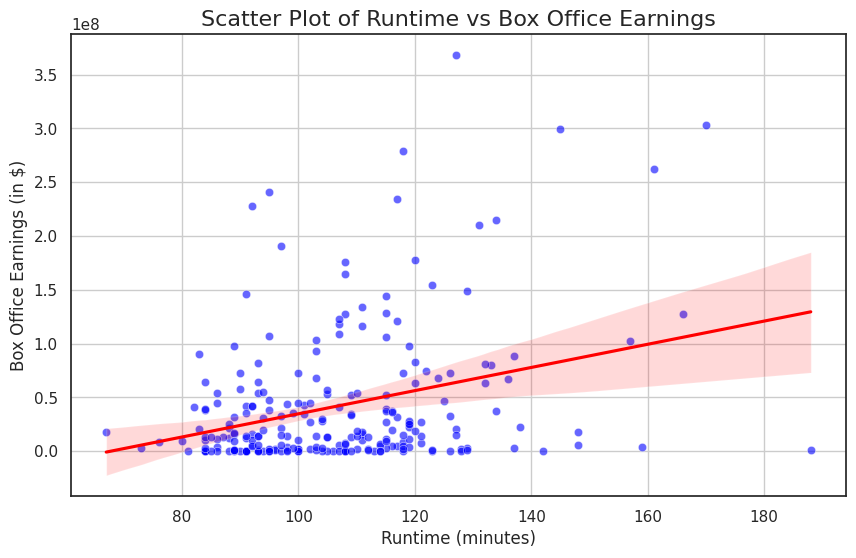

In [682]:

# Scatter plot of runtime vs box office earnings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned2, x='runtime', y='box_office', color='blue', alpha=0.6)

# Adding a regression line
sns.regplot(data=df_cleaned2, x='runtime', y='box_office', scatter=False, color='red')

# Customize the plot
plt.title('Scatter Plot of Runtime vs Box Office Earnings', fontsize=16)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Box Office Earnings (in $)', fontsize=12)
plt.grid(True)

# Show plot
plt.show()


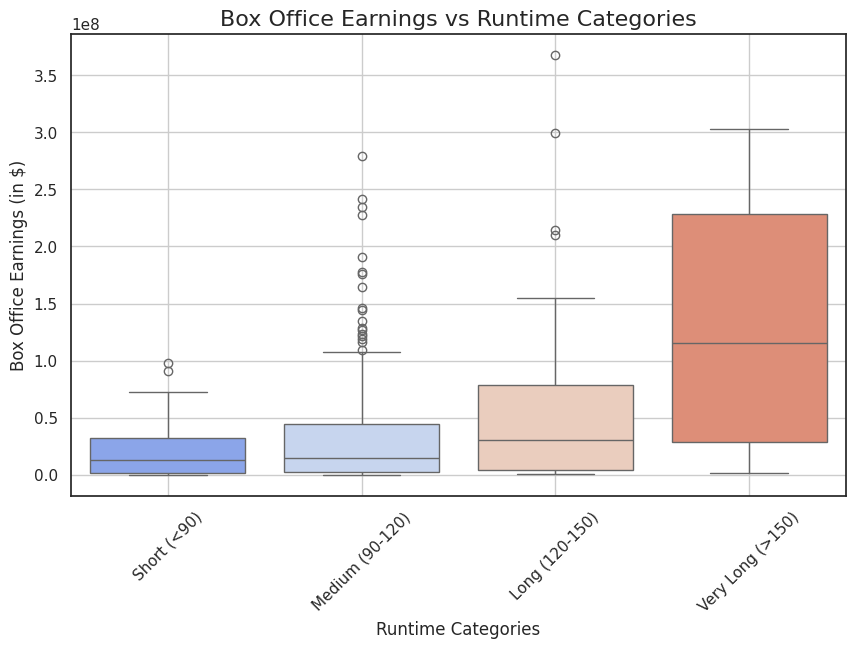

In [683]:
# Define bins for runtime (e.g., short, medium, long)
bins = [0, 90, 120, 150, np.inf]
labels = ['Short (<90)', 'Medium (90-120)', 'Long (120-150)', 'Very Long (>150)']
df_cleaned2['runtime_category'] = pd.cut(df_cleaned2['runtime'], bins=bins, labels=labels)

# Box plot of Box Office vs Runtime Categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned2, x='runtime_category', y='box_office', palette='coolwarm')

# Customize the plot
plt.title('Box Office Earnings vs Runtime Categories', fontsize=16)
plt.xlabel('Runtime Categories', fontsize=12)
plt.ylabel('Box Office Earnings (in $)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()


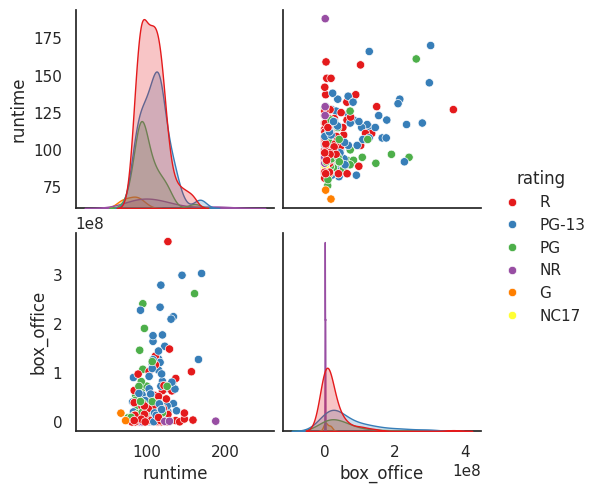

In [684]:
# Pair plot of runtime, box office, and other variables (e.g., rating)
sns.pairplot(df_cleaned2[['runtime', 'box_office', 'rating']], hue='rating', palette='Set1')

# Show plot
plt.show()


WHICH GENRE HAD THE HIGHEST BOX OFFICE EARNINGS?

In [685]:
# extract the first genre
df_cleaned2['primary_genre'] = df_cleaned2['genre'].str.split('|').str[0]

# Group by primary genre and calculate the average box office earnings
genre_box_office = df_cleaned2.groupby('primary_genre')['box_office'].mean().sort_values(ascending=False)

# Display the top genres with the highest average box office earnings
print(genre_box_office)


primary_genre
Science Fiction and Fantasy    1.908711e+08
Kids and Family                1.319315e+08
Action and Adventure           7.606785e+07
Animation                      4.127259e+07
Comedy                         4.020952e+07
Drama                          2.864056e+07
Horror                         2.028152e+07
Art House and International    1.432253e+06
Documentary                    3.392757e+05
Name: box_office, dtype: float64


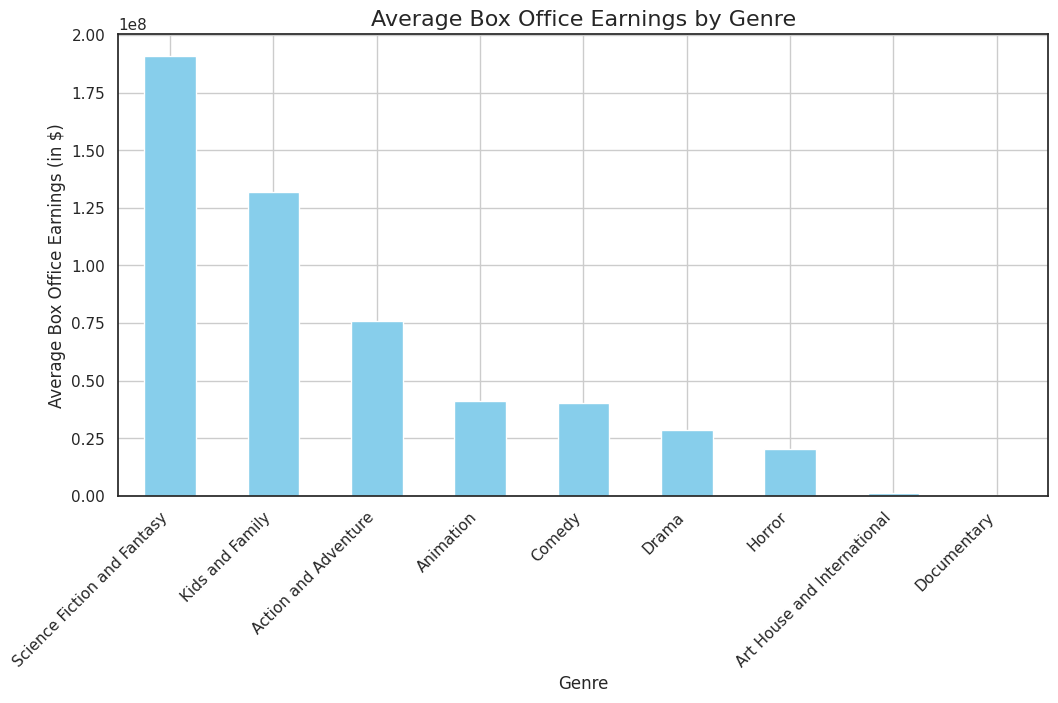

In [686]:

# Plot the results
plt.figure(figsize=(12, 6))
genre_box_office.plot(kind='bar', color='skyblue')

# Customize the plot
plt.title('Average Box Office Earnings by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Box Office Earnings (in $)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Show the plot
plt.show()


In [687]:
# Group by movie rating and calculate the average box office earnings
rating_box_office = df_cleaned2.groupby('rating')['box_office'].mean().sort_values(ascending=False)

# Display the average box office earnings for each rating
print(rating_box_office)


rating
PG-13    6.872359e+07
PG       5.289280e+07
R        2.394827e+07
G        7.402788e+06
NC17     1.260219e+06
NR       6.376923e+05
Name: box_office, dtype: float64


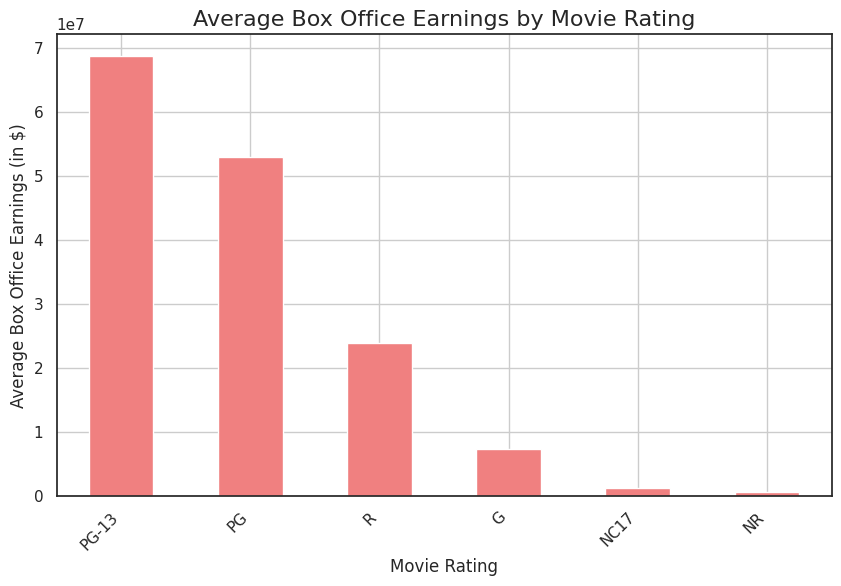

In [688]:

# Plot the results
plt.figure(figsize=(10, 6))
rating_box_office.plot(kind='bar', color='lightcoral')

# Customize the plot
plt.title('Average Box Office Earnings by Movie Rating', fontsize=16)
plt.xlabel('Movie Rating', fontsize=12)
plt.ylabel('Average Box Office Earnings (in $)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Show the plot
plt.show()


In [689]:
# Group by director and calculate the average box office earnings
director_box_office = df_cleaned2.groupby('director')['box_office'].mean().sort_values(ascending=False)

# Display the directors with the highest average box office earnings
print(director_box_office.head())


director
Mel Gibson          368000000.0
Peter Jackson       303001229.0
Chris Columbus      261835892.0
Joel Zwick          241250669.0
Steven Spielberg    234141872.0
Name: box_office, dtype: float64


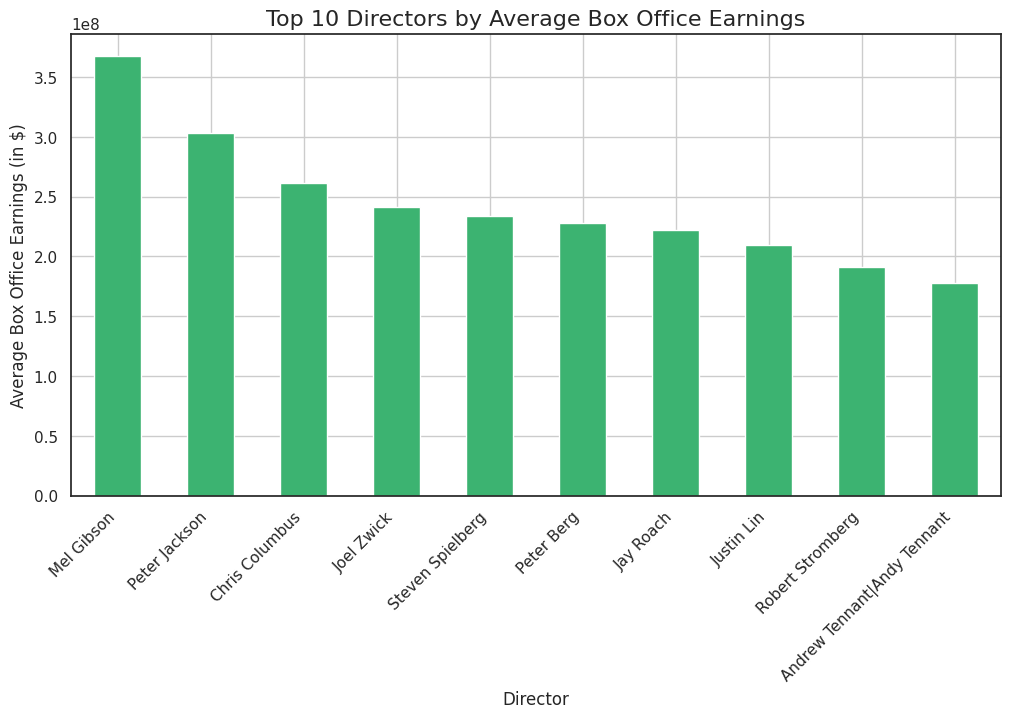

In [690]:


# Plot the results (top 10 directors for better readability)
top_directors = director_box_office.head(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
top_directors.plot(kind='bar', color='mediumseagreen')

# Customize the plot
plt.title('Top 10 Directors by Average Box Office Earnings', fontsize=16)
plt.xlabel('Director', fontsize=12)
plt.ylabel('Average Box Office Earnings (in $)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Show the plot
plt.show()


In [691]:
# Group by studio and calculate the average box office earnings
studio_box_office = df_cleaned2.groupby('studio')['box_office'].mean().sort_values(ascending=False)

# Display the studios with the highest average box office earnings
print(studio_box_office.head())  # Display the top studios with the highest earnings


studio
Newmarket Film Group               201093893.5
Universal                          148734225.0
Sony Pictures/Columbia Pictures    146336178.0
DreamWorks SKG                     128579698.0
Paramount                          127490802.0
Name: box_office, dtype: float64


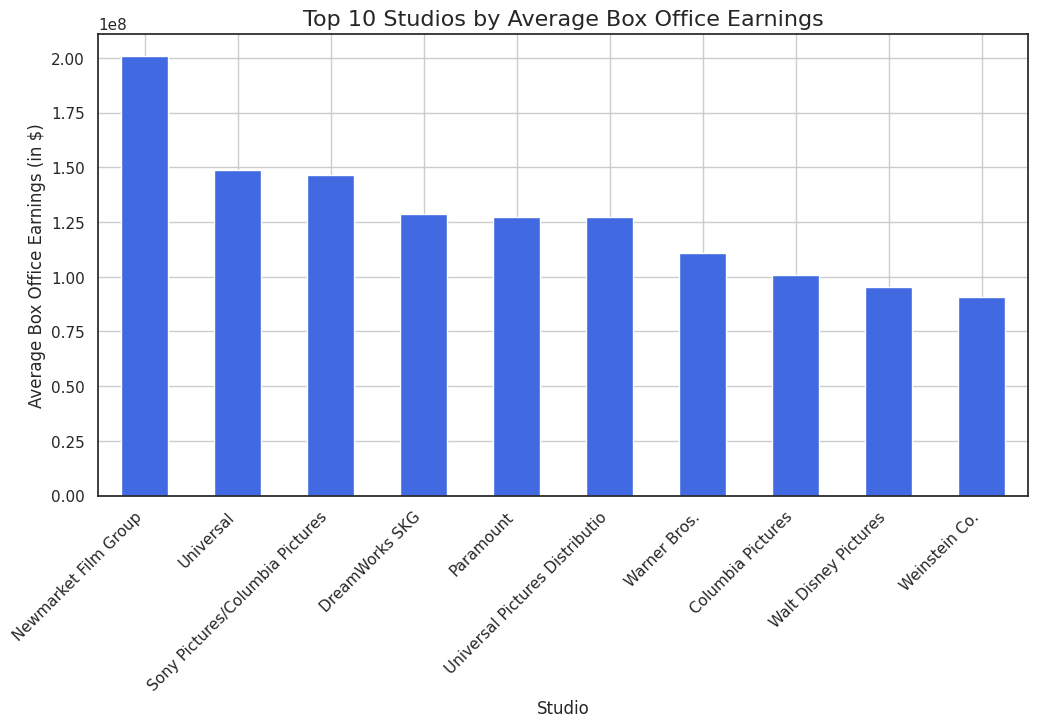

In [692]:

# Plot the results (top 10 studios for better readability)
top_studios = studio_box_office.head(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
top_studios.plot(kind='bar', color='royalblue')

# Customize the plot
plt.title('Top 10 Studios by Average Box Office Earnings', fontsize=16)
plt.xlabel('Studio', fontsize=12)
plt.ylabel('Average Box Office Earnings (in $)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Show the plot
plt.show()


### **Conclusions**  

1. **Genre Influence on Financial Success**: Genres such as Drama, Action, and Documentary consistently achieve high audience ratings and substantial box office revenues. This highlights the importance of genre selection in maximizing financial outcomes.  

2. **Impact of Budget and Production Quality**: Larger production budgets often translate to better financial performance, as higher investments in cast, crew, and visuals tend to attract wider audiences.  

3. **Star Power and Box Office Success**: Films featuring well-known actors and directors generally perform better, suggesting that leveraging star power is a critical factor in driving audience engagement and revenues.  

4. **Domestic-International Link**: A strong correlation exists between domestic and international grosses, indicating that domestic success can significantly enhance a film’s global appeal and performance.  

5. **Runtime and Audience Engagement**: Moderately long movies (e.g., 120–150 minutes) tend to perform well, balancing audience engagement without overwhelming them.  

---

### **Recommendations**  

1. **Invest in High-Rating Genres**  
   - Focus on producing films in Drama, Action, and Documentary genres to capture consistently engaged audiences. Explore sub-genres such as Crime or Biography to appeal to niche markets.  

2. **Optimize Runtime for Success**  
   - Target runtimes between 120–150 minutes to strike a balance between audience satisfaction and financial performance, as excessively long or short films may deter viewers.  

3. **Leverage Star Power**  
   - Collaborate with renowned actors and directors to increase the likelihood of commercial success, as their involvement significantly boosts audience interest and box office returns.  

4. **Expand International Marketing**  
   - Utilize the strong domestic-foreign gross correlation by tailoring marketing strategies to global audiences, especially for movies that perform well domestically.  

5. **Monitor and Adapt to Trends**  
   - Continuously analyze yearly trends and audience preferences to identify emerging genres or themes, ensuring content aligns with current market demands and maximizes profitability.  



### **Next Steps**  

1. **Analyze Studio Performance**  
   - Look deeper into how different studios perform financially to find key players and potential partners.  

2. **Study Yearly Trends**  
   - Review how movie revenues and audience preferences change each year to plan better release strategies.  

3. **Understand Audience Groups**  
   - Break down audience data by age, gender, and region to target specific groups with the right genres or runtimes.  

4. **Focus on Global Markets**  
   - Explore new regions or countries where movies could perform well to reach more audiences and grow revenue.  

5. **Test Budget Strategies**  
   - Create movies with different budget sizes to see which approach gives the best return and works best for specific genres.  
